# DNN and CNN using Keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# to set data path
dataPath = 'https://raw.githubusercontent.com/stillxyxon/py_ml_analysis/master/'

# YONG's local data path
# dataPath = 'C:/YONG/m1710/myPydata/'


def rjitt2(arr):
    stdev = .031*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt3(arr):
    stdev = .1*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def mnmx_scl2(vec):
    vec = np.where(np.percentile(vec, 95) < vec,
                   np.percentile(vec, 95), vec)
    vec = np.array(vec)
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

# custom one-hot encoder
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

# print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
# combined = oneHotEncode(combined, cat_cols)


## DNN for Classication 

### 보험료 추정 예제

In [229]:
dfi01 = pd.read_csv(dataPath + 'insurance_charge.csv')
print(dfi01.columns)
print(dfi01.shape)

# check if any null
print('any null? ', dfi01.isnull().any())
dfi01.head()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
(1338, 7)
any null?  age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
# include numeric variables only
dfi02 = dfi01[['age','sex','bmi','children','smoker','charges']]
dfi02.head()

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


In [47]:
# transform binary categorical variables into numeric

dfi02['is_female'] = np.where(dfi02.sex=='female',1,0)
dfi02['is_smoker'] = np.where(dfi02.smoker=='yes',1,0)
dfi02 = dfi02[['age','is_female','bmi','children','is_smoker','charges']]
dfi02.head()

,age,is_female,bmi,children,is_smoker,charges
0,19,1,27.900,0,1,16884.92400
1,18,0,33.770,1,0,1725.55230
2,28,0,33.000,3,0,4449.46200
3,33,0,22.705,0,0,21984.47061
4,32,0,28.880,0,0,3866.85520


   age  is_female    bmi  children  is_smoker
0   19          1  27.90         0          1
1   18          0  33.77         1          0
2   28          0  33.00         3          0


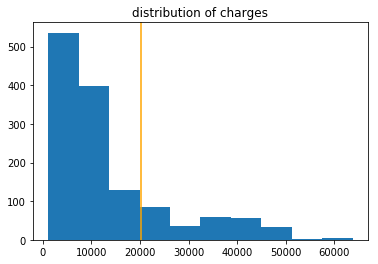

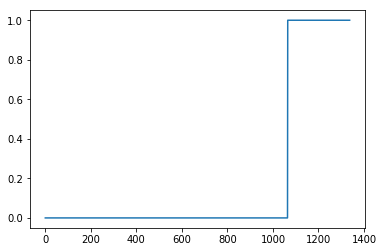

In [48]:
from sklearn.model_selection import train_test_split

# Specify the data 
X = dfi02.ix[:,0:5]
print(X.head(3))

# 타겟인 charges의 분포를 살펴보고
plt.hist(dfi02.charges)
plt.axvline(np.percentile(dfi02.charges,80), color='orange')
plt.title('distribution of charges')
plt.plot()
plt.show()

# 상위 20% 가량에 해당하는 20000 이상을 
# high 그룹으로 지정해서 classification target으로 설정

bin_tgt = np.where(dfi02.charges>=20000, 1, 0)
plt.plot(np.sort(bin_tgt))
plt.show()

y = bin_tgt

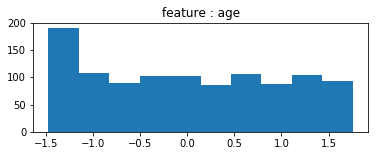

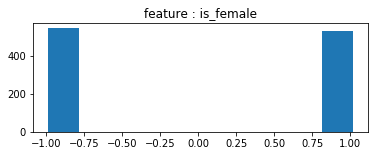

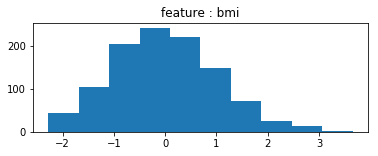

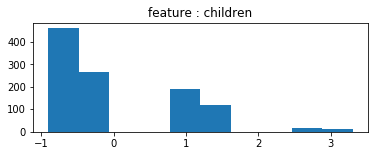

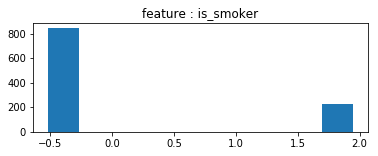

In [122]:
# [Partitioning] 
# Split the data up in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


# [Scaling Inputs]

# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set based on train set distribution
X_train = scaler.transform(X_train)

# Scale the test set based on train set distribution
X_test = scaler.transform(X_test)

features_ = dfi02.ix[:,0:5].columns
# check the dstributions after scaling
for x in range(len(features_)):
    plt.figure(figsize=(6,2))
    plt.hist(X_train[:,x])
    title = 'feature : ' + features_[x]
    plt.title(title)
    plt.show()
    


In [242]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(5, activation='sigmoid', input_shape=(5,)))

num_layers = 1 
nnode = 2

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='sigmoid')) # activation = ['sigmoid', 'relu']

# Add an output layer 
model.add(Dense(1,  activation='sigmoid'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_93 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [255]:
# fitting (training) DNN

import datetime
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='sgd', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=900, batch_size=64,
                    verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2019-10-22 13:58:09.070133
Train on 856 samples, validate on 214 samples
Epoch 1/900
856/856 [==============================] - 2s 3ms/step - loss: 0.2290 - acc: 0.9404 - val_loss: 0.2777 - val_acc: 0.9252
Epoch 2/900
856/856 [==============================] - 0s 52us/step - loss: 0.2290 - acc: 0.9404 - val_loss: 0.2778 - val_acc: 0.9252
Epoch 3/900
856/856 [==============================] - 0s 59us/step - loss: 0.2290 - acc: 0.9404 - val_loss: 0.2778 - val_acc: 0.9252
Epoch 4/900
856/856 [==============================] - 0s 49us/step - loss: 0.2290 - acc: 0.9404 - val_loss: 0.2777 - val_acc: 0.9252
Epoch 5/900
856/856 [==============================] - 0s 36us/step - loss: 0.2290 - acc: 0.9404 - val_loss: 0.2776 - val_acc: 0.9252
Epoch 6/900
856/856 [==============================] - 0s 43us/step - loss: 0.2289 - acc: 0.9404 - val_loss: 0.2776 - val_acc: 0.9252
Epoch 7/900
856/856 [==============================] - 0s 42us/step - loss: 0.2289 - acc: 0.9404 - val_loss: 0.2776

856/856 [==============================] - 0s 42us/step - loss: 0.2279 - acc: 0.9404 - val_loss: 0.2761 - val_acc: 0.9252
Epoch 62/900
856/856 [==============================] - 0s 43us/step - loss: 0.2279 - acc: 0.9404 - val_loss: 0.2762 - val_acc: 0.9252
Epoch 63/900
856/856 [==============================] - 0s 41us/step - loss: 0.2279 - acc: 0.9404 - val_loss: 0.2762 - val_acc: 0.9252
Epoch 64/900
856/856 [==============================] - 0s 45us/step - loss: 0.2279 - acc: 0.9416 - val_loss: 0.2763 - val_acc: 0.9252
Epoch 65/900
856/856 [==============================] - 0s 43us/step - loss: 0.2279 - acc: 0.9404 - val_loss: 0.2763 - val_acc: 0.9252
Epoch 66/900
856/856 [==============================] - 0s 43us/step - loss: 0.2278 - acc: 0.9404 - val_loss: 0.2762 - val_acc: 0.9252
Epoch 67/900
856/856 [==============================] - 0s 44us/step - loss: 0.2278 - acc: 0.9404 - val_loss: 0.2761 - val_acc: 0.9252
Epoch 68/900
856/856 [==============================] - 0s 44us/step

856/856 [==============================] - 0s 42us/step - loss: 0.2269 - acc: 0.9404 - val_loss: 0.2752 - val_acc: 0.9252
Epoch 122/900
856/856 [==============================] - 0s 47us/step - loss: 0.2269 - acc: 0.9404 - val_loss: 0.2752 - val_acc: 0.9252
Epoch 123/900
856/856 [==============================] - 0s 47us/step - loss: 0.2269 - acc: 0.9416 - val_loss: 0.2752 - val_acc: 0.9252
Epoch 124/900
856/856 [==============================] - 0s 42us/step - loss: 0.2269 - acc: 0.9404 - val_loss: 0.2753 - val_acc: 0.9252
Epoch 125/900
856/856 [==============================] - 0s 50us/step - loss: 0.2269 - acc: 0.9404 - val_loss: 0.2752 - val_acc: 0.9252
Epoch 126/900
856/856 [==============================] - 0s 43us/step - loss: 0.2268 - acc: 0.9404 - val_loss: 0.2751 - val_acc: 0.9252
Epoch 127/900
856/856 [==============================] - 0s 41us/step - loss: 0.2268 - acc: 0.9416 - val_loss: 0.2751 - val_acc: 0.9252
Epoch 128/900
856/856 [==============================] - 0s 44

856/856 [==============================] - 0s 47us/step - loss: 0.2260 - acc: 0.9416 - val_loss: 0.2740 - val_acc: 0.9252
Epoch 182/900
856/856 [==============================] - 0s 56us/step - loss: 0.2260 - acc: 0.9416 - val_loss: 0.2739 - val_acc: 0.9252
Epoch 183/900
856/856 [==============================] - 0s 59us/step - loss: 0.2260 - acc: 0.9404 - val_loss: 0.2739 - val_acc: 0.9252
Epoch 184/900
856/856 [==============================] - 0s 47us/step - loss: 0.2259 - acc: 0.9404 - val_loss: 0.2738 - val_acc: 0.9252
Epoch 185/900
856/856 [==============================] - 0s 45us/step - loss: 0.2259 - acc: 0.9404 - val_loss: 0.2738 - val_acc: 0.9252
Epoch 186/900
856/856 [==============================] - 0s 42us/step - loss: 0.2259 - acc: 0.9404 - val_loss: 0.2738 - val_acc: 0.9252
Epoch 187/900
856/856 [==============================] - 0s 44us/step - loss: 0.2259 - acc: 0.9416 - val_loss: 0.2738 - val_acc: 0.9252
Epoch 188/900
856/856 [==============================] - 0s 45

856/856 [==============================] - 0s 48us/step - loss: 0.2251 - acc: 0.9416 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 242/900
856/856 [==============================] - 0s 45us/step - loss: 0.2251 - acc: 0.9416 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 243/900
856/856 [==============================] - 0s 49us/step - loss: 0.2251 - acc: 0.9416 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 244/900
856/856 [==============================] - 0s 43us/step - loss: 0.2251 - acc: 0.9416 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 245/900
856/856 [==============================] - 0s 42us/step - loss: 0.2251 - acc: 0.9404 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 246/900
856/856 [==============================] - 0s 47us/step - loss: 0.2251 - acc: 0.9416 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 247/900
856/856 [==============================] - 0s 49us/step - loss: 0.2250 - acc: 0.9404 - val_loss: 0.2731 - val_acc: 0.9252
Epoch 248/900
856/856 [==============================] - 0s 54

856/856 [==============================] - 0s 47us/step - loss: 0.2243 - acc: 0.9404 - val_loss: 0.2724 - val_acc: 0.9252
Epoch 302/900
856/856 [==============================] - 0s 45us/step - loss: 0.2243 - acc: 0.9416 - val_loss: 0.2724 - val_acc: 0.9252
Epoch 303/900
856/856 [==============================] - 0s 38us/step - loss: 0.2243 - acc: 0.9416 - val_loss: 0.2723 - val_acc: 0.9252
Epoch 304/900
856/856 [==============================] - 0s 44us/step - loss: 0.2243 - acc: 0.9416 - val_loss: 0.2723 - val_acc: 0.9252
Epoch 305/900
856/856 [==============================] - 0s 47us/step - loss: 0.2243 - acc: 0.9416 - val_loss: 0.2723 - val_acc: 0.9252
Epoch 306/900
856/856 [==============================] - 0s 55us/step - loss: 0.2243 - acc: 0.9416 - val_loss: 0.2723 - val_acc: 0.9252
Epoch 307/900
856/856 [==============================] - 0s 48us/step - loss: 0.2242 - acc: 0.9416 - val_loss: 0.2722 - val_acc: 0.9252
Epoch 308/900
856/856 [==============================] - 0s 51

856/856 [==============================] - 0s 59us/step - loss: 0.2236 - acc: 0.9404 - val_loss: 0.2718 - val_acc: 0.9252
Epoch 362/900
856/856 [==============================] - 0s 55us/step - loss: 0.2236 - acc: 0.9404 - val_loss: 0.2718 - val_acc: 0.9252
Epoch 363/900
856/856 [==============================] - 0s 49us/step - loss: 0.2236 - acc: 0.9404 - val_loss: 0.2717 - val_acc: 0.9252
Epoch 364/900
856/856 [==============================] - 0s 50us/step - loss: 0.2236 - acc: 0.9404 - val_loss: 0.2717 - val_acc: 0.9252
Epoch 365/900
856/856 [==============================] - 0s 44us/step - loss: 0.2235 - acc: 0.9404 - val_loss: 0.2717 - val_acc: 0.9252
Epoch 366/900
856/856 [==============================] - 0s 43us/step - loss: 0.2235 - acc: 0.9404 - val_loss: 0.2716 - val_acc: 0.9252
Epoch 367/900
856/856 [==============================] - 0s 50us/step - loss: 0.2235 - acc: 0.9404 - val_loss: 0.2716 - val_acc: 0.9252
Epoch 368/900
856/856 [==============================] - 0s 44

856/856 [==============================] - 0s 42us/step - loss: 0.2229 - acc: 0.9404 - val_loss: 0.2704 - val_acc: 0.9252
Epoch 422/900
856/856 [==============================] - 0s 41us/step - loss: 0.2229 - acc: 0.9404 - val_loss: 0.2705 - val_acc: 0.9252
Epoch 423/900
856/856 [==============================] - 0s 42us/step - loss: 0.2229 - acc: 0.9416 - val_loss: 0.2705 - val_acc: 0.9252
Epoch 424/900
856/856 [==============================] - 0s 44us/step - loss: 0.2229 - acc: 0.9416 - val_loss: 0.2704 - val_acc: 0.9252
Epoch 425/900
856/856 [==============================] - 0s 45us/step - loss: 0.2228 - acc: 0.9404 - val_loss: 0.2705 - val_acc: 0.9252
Epoch 426/900
856/856 [==============================] - 0s 50us/step - loss: 0.2228 - acc: 0.9416 - val_loss: 0.2704 - val_acc: 0.9252
Epoch 427/900
856/856 [==============================] - 0s 44us/step - loss: 0.2228 - acc: 0.9416 - val_loss: 0.2705 - val_acc: 0.9252
Epoch 428/900
856/856 [==============================] - 0s 44

856/856 [==============================] - 0s 45us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2699 - val_acc: 0.9252
Epoch 482/900
856/856 [==============================] - 0s 48us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2698 - val_acc: 0.9252
Epoch 483/900
856/856 [==============================] - 0s 41us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2697 - val_acc: 0.9252
Epoch 484/900
856/856 [==============================] - 0s 45us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2698 - val_acc: 0.9252
Epoch 485/900
856/856 [==============================] - 0s 45us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2698 - val_acc: 0.9252
Epoch 486/900
856/856 [==============================] - 0s 41us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2697 - val_acc: 0.9252
Epoch 487/900
856/856 [==============================] - 0s 44us/step - loss: 0.2222 - acc: 0.9416 - val_loss: 0.2697 - val_acc: 0.9252
Epoch 488/900
856/856 [==============================] - 0s 47

856/856 [==============================] - 0s 41us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2692 - val_acc: 0.9252
Epoch 542/900
856/856 [==============================] - 0s 48us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2692 - val_acc: 0.9252
Epoch 543/900
856/856 [==============================] - 0s 44us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2692 - val_acc: 0.9252
Epoch 544/900
856/856 [==============================] - 0s 44us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2692 - val_acc: 0.9252
Epoch 545/900
856/856 [==============================] - 0s 41us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2692 - val_acc: 0.9252
Epoch 546/900
856/856 [==============================] - 0s 47us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2693 - val_acc: 0.9252
Epoch 547/900
856/856 [==============================] - 0s 44us/step - loss: 0.2216 - acc: 0.9416 - val_loss: 0.2693 - val_acc: 0.9252
Epoch 548/900
856/856 [==============================] - 0s 42

856/856 [==============================] - 0s 44us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2686 - val_acc: 0.9252
Epoch 602/900
856/856 [==============================] - 0s 48us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2687 - val_acc: 0.9252
Epoch 603/900
856/856 [==============================] - 0s 42us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2687 - val_acc: 0.9252
Epoch 604/900
856/856 [==============================] - 0s 51us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2687 - val_acc: 0.9252
Epoch 605/900
856/856 [==============================] - 0s 38us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2686 - val_acc: 0.9252
Epoch 606/900
856/856 [==============================] - 0s 47us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2686 - val_acc: 0.9252
Epoch 607/900
856/856 [==============================] - 0s 45us/step - loss: 0.2210 - acc: 0.9416 - val_loss: 0.2687 - val_acc: 0.9252
Epoch 608/900
856/856 [==============================] - 0s 52

856/856 [==============================] - 0s 48us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2682 - val_acc: 0.9252
Epoch 662/900
856/856 [==============================] - 0s 42us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2682 - val_acc: 0.9252
Epoch 663/900
856/856 [==============================] - 0s 41us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2683 - val_acc: 0.9252
Epoch 664/900
856/856 [==============================] - 0s 43us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2682 - val_acc: 0.9252
Epoch 665/900
856/856 [==============================] - 0s 47us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2681 - val_acc: 0.9252
Epoch 666/900
856/856 [==============================] - 0s 47us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2681 - val_acc: 0.9252
Epoch 667/900
856/856 [==============================] - 0s 47us/step - loss: 0.2205 - acc: 0.9416 - val_loss: 0.2681 - val_acc: 0.9252
Epoch 668/900
856/856 [==============================] - 0s 44

856/856 [==============================] - 0s 43us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2676 - val_acc: 0.9252
Epoch 722/900
856/856 [==============================] - 0s 47us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2677 - val_acc: 0.9252
Epoch 723/900
856/856 [==============================] - 0s 41us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2676 - val_acc: 0.9252
Epoch 724/900
856/856 [==============================] - 0s 47us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2675 - val_acc: 0.9252
Epoch 725/900
856/856 [==============================] - 0s 47us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2675 - val_acc: 0.9252
Epoch 726/900
856/856 [==============================] - 0s 44us/step - loss: 0.2200 - acc: 0.9416 - val_loss: 0.2675 - val_acc: 0.9252
Epoch 727/900
856/856 [==============================] - 0s 48us/step - loss: 0.2199 - acc: 0.9416 - val_loss: 0.2675 - val_acc: 0.9252
Epoch 728/900
856/856 [==============================] - 0s 45

856/856 [==============================] - 0s 44us/step - loss: 0.2195 - acc: 0.9404 - val_loss: 0.2667 - val_acc: 0.9252
Epoch 782/900
856/856 [==============================] - 0s 49us/step - loss: 0.2195 - acc: 0.9416 - val_loss: 0.2667 - val_acc: 0.9252
Epoch 783/900
856/856 [==============================] - 0s 45us/step - loss: 0.2195 - acc: 0.9416 - val_loss: 0.2667 - val_acc: 0.9252
Epoch 784/900
856/856 [==============================] - 0s 43us/step - loss: 0.2195 - acc: 0.9416 - val_loss: 0.2667 - val_acc: 0.9252
Epoch 785/900
856/856 [==============================] - 0s 48us/step - loss: 0.2195 - acc: 0.9416 - val_loss: 0.2666 - val_acc: 0.9252
Epoch 786/900
856/856 [==============================] - 0s 44us/step - loss: 0.2195 - acc: 0.9416 - val_loss: 0.2666 - val_acc: 0.9252
Epoch 787/900
856/856 [==============================] - 0s 50us/step - loss: 0.2195 - acc: 0.9404 - val_loss: 0.2667 - val_acc: 0.9252
Epoch 788/900
856/856 [==============================] - 0s 41

856/856 [==============================] - 0s 48us/step - loss: 0.2191 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 842/900
856/856 [==============================] - 0s 43us/step - loss: 0.2191 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 843/900
856/856 [==============================] - 0s 45us/step - loss: 0.2191 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 844/900
856/856 [==============================] - 0s 47us/step - loss: 0.2190 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 845/900
856/856 [==============================] - 0s 50us/step - loss: 0.2190 - acc: 0.9416 - val_loss: 0.2664 - val_acc: 0.9252
Epoch 846/900
856/856 [==============================] - 0s 41us/step - loss: 0.2190 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 847/900
856/856 [==============================] - 0s 43us/step - loss: 0.2190 - acc: 0.9416 - val_loss: 0.2663 - val_acc: 0.9252
Epoch 848/900
856/856 [==============================] - 0s 41

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


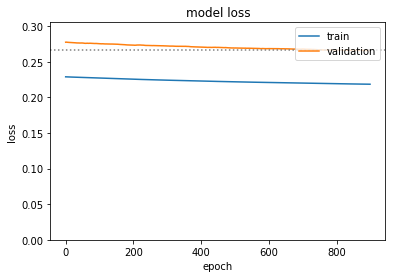

range of prediction :  0.04288494 0.9649304
1070/1070 [==============================] - 0s 34us/step

Accuracy: 93.83

Confusion Matrix : 
 [[840   8]
 [ 58 164]]


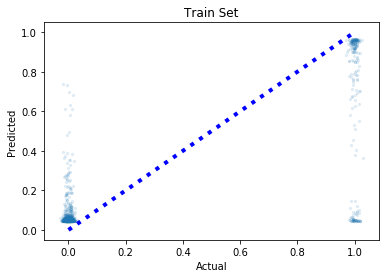

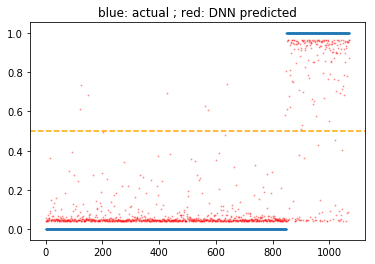

train actual and predicted corr =  0.80652
MAE =  0.1232

r_sqrd =  0.647


In [256]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


y_train_pred = model.predict(X_train)
# y_train_pred = np.where(y_train_pred <0, 0, y_train_pred)
# y_train_pred = np.where(y_train_pred >1, 1, y_train_pred)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())

# evaluate model :: check accuracy
_, accuracy = model.evaluate(X_train, y_train)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics
y_train_pred_cl = np.where(y_train_pred>=0.5,1,0)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred_cl)
print('\nConfusion Matrix : \n', cnf_matrix)

#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train), y_train_pred, alpha=0.1, s=5)
ax.plot([y_train.min(), 1], [y_train.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))



- Loss 커브의 ideal한 모습
    * 점점 loss 감소
    * train과 validation 유사
    * 커브에 spike, fluctuation이 없는 안정적인 패턴

### Fully Equipped DNN Classifier

In [257]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(5, activation='relu', input_shape=(5,)))

num_layers = 5
nnode = 512

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='relu')) # activation = ['sigmoid', 'relu']
    model.add(Dropout(0.5))
    node = int(nnode/2)

# Add an output layer 
model.add(Dense(1,  activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_96 (Dense)             (None, 512)               3072      
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
__________

In [258]:
# fitting (training) DNN

import datetime

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2019-10-22 13:59:31.339149
Train on 856 samples, validate on 214 samples
Epoch 1/50
856/856 [==============================] - 4s 5ms/step - loss: 0.5207 - acc: 0.7932 - val_loss: 0.3894 - val_acc: 0.8879
Epoch 2/50
856/856 [==============================] - 2s 2ms/step - loss: 0.3444 - acc: 0.8995 - val_loss: 0.3470 - val_acc: 0.8598
Epoch 3/50
856/856 [==============================] - 1s 2ms/step - loss: 0.3107 - acc: 0.9077 - val_loss: 0.3006 - val_acc: 0.8925
Epoch 4/50
856/856 [==============================] - 1s 2ms/step - loss: 0.3012 - acc: 0.9077 - val_loss: 0.3113 - val_acc: 0.8879
Epoch 5/50
856/856 [==============================] - 2s 2ms/step - loss: 0.2739 - acc: 0.9171 - val_loss: 0.3062 - val_acc: 0.9019
Epoch 6/50
856/856 [==============================] - 1s 2ms/step - loss: 0.2932 - acc: 0.9147 - val_loss: 0.2613 - val_acc: 0.9346
Epoch 7/50
856/856 [==============================] - 1s 2ms/step - loss: 0.2602 - acc: 0.9229 - val_loss: 0.2879 - val_acc: 0

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


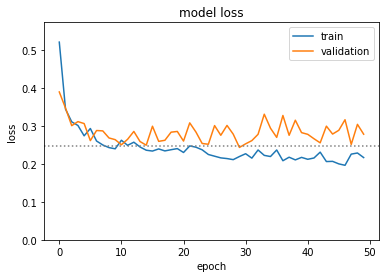

range of prediction :  0.00017422657 1.0
1070/1070 [==============================] - 0s 143us/step

Accuracy: 94.21

Confusion Matrix : 
 [[846   2]
 [ 60 162]]


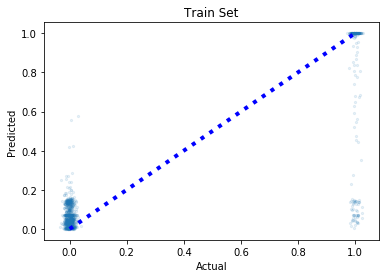

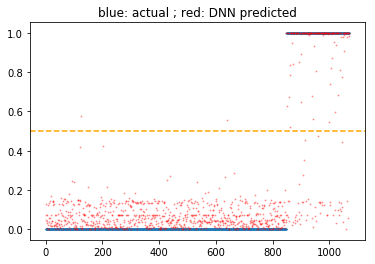

train actual and predicted corr =  0.82655
MAE =  0.10778

r_sqrd =  0.683


---


range of prediction :  0.00043750976 1.0
268/268 [==============================] - 0s 134us/step

Accuracy: 95.15
AUC: 0.908


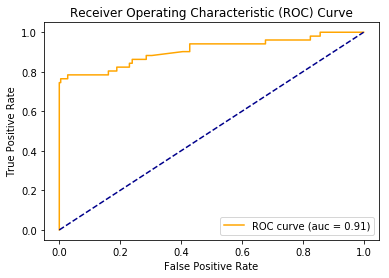


Confusion Matrix : 
 [[217   0]
 [ 13  38]]


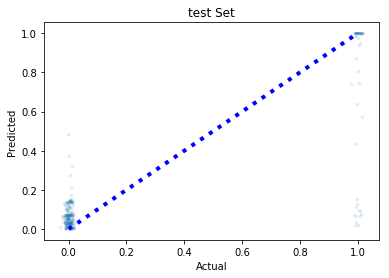

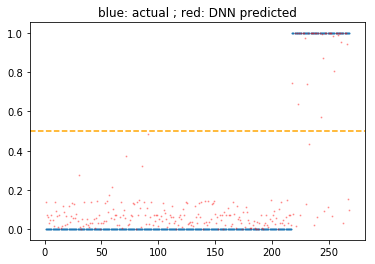

test actual and predicted corr =  0.8306
MAE =  0.10524

r_sqrd =  0.689


In [278]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


y_train_pred = model.predict(X_train)
# y_train_pred = np.where(y_train_pred <0, 0, y_train_pred)
# y_train_pred = np.where(y_train_pred >1, 1, y_train_pred)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())

# evaluate model :: check accuracy
_, accuracy = model.evaluate(X_train, y_train)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics
y_train_pred_cl = np.where(y_train_pred>=0.5,1,0)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred_cl)
print('\nConfusion Matrix : \n', cnf_matrix)

#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train), y_train_pred, alpha=0.1, s=5)
ax.plot([y_train.min(), 1], [y_train.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print("\n\n---\n\n")


y_test_pred = model.predict(X_test)
# y_test_pred = np.where(y_test_pred <0, 0, y_test_pred)
# y_test_pred = np.where(y_test_pred >1, 1, y_test_pred)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())

# evaluate model :: check accuracy
_, accuracy = model.evaluate(X_test, y_test)
print('\nAccuracy: %.2f' % (accuracy*100))


auc = roc_auc_score(y_test, y_test_pred)
print('AUC: %.3f' % auc)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (auc = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)    
plot_roc_curve(fpr, tpr)



# import the metrics class
from sklearn import metrics
y_test_pred_cl = np.where(y_test_pred>=0.5,1,0)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred_cl)
print('\nConfusion Matrix : \n', cnf_matrix)

#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test), y_test_pred, alpha=0.1, s=5)
ax.plot([y_test.min(), 1], [y_test.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_test, 
              'y_pred': np.reshape(y_test_pred,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(y_test, np.reshape(y_test_pred,len(y_test)))[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_test, np.reshape(y_test_pred,len(y_test))),3))




### CatBoost for comparison

   age     sex     bmi  children smoker     region
0   19  female  27.900         0    yes  southwest
1   18    male  33.770         1     no  southeast
2   28    male  33.000         3     no  southeast
3   33    male  22.705         0     no  northwest
4   32    male  28.880         0     no  northwest
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object
[1 4 5]
0:	learn: 0.9037383	test: 0.9037383	best: 0.9037383 (0)	total: 54.4ms	remaining: 54.3s
100:	learn: 0.9467290	test: 0.9457944	best: 0.9457944 (100)	total: 4.1s	remaining: 36.5s
200:	learn: 0.9570093	test: 0.9495327	best: 0.9495327 (200)	total: 11.3s	remaining: 45s
300:	learn: 0.9728972	test: 0.9570093	best: 0.9570093 (300)	total: 19.9s	remaining: 46.2s
400:	learn: 0.9887850	test: 0.9616822	best: 0.9616822 (400)	total: 28.6s	remaining: 42.8s
500:	learn: 0.9915888	test: 0.9682243	best: 0.9682243 (500)	total: 37.3s	remaining: 37.1s
600:	learn: 0.9990

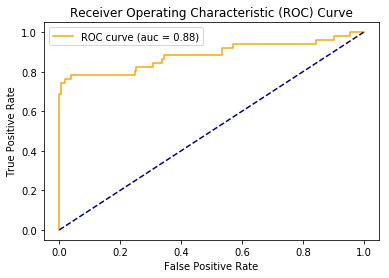


Confusion Matrix (test set) :
 [[214   3]
 [ 13  38]]
PCNT accuracy = 94.03 
range of prediction :  5.526372694709856e-05 0.999986179277992


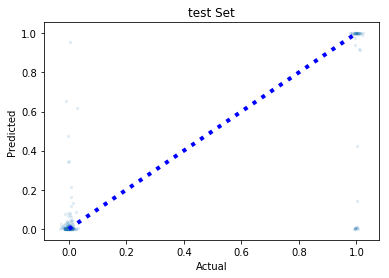

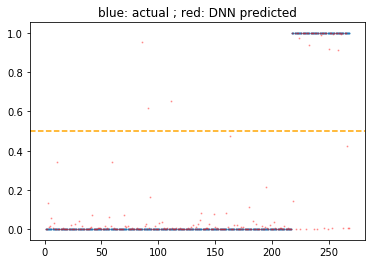

test actual and predicted corr =  0.81414
MAE =  0.06873

r_sqrd =  0.653


In [209]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

dfdt = dfi01.ix[:,:6]
tgt = bin_tgt

print(dfdt.head())

categorical_features_indices = np.where(dfdt.dtypes ==np.object)[0]
print(dfdt.dtypes)
print(categorical_features_indices)

# Partitioning
trainX, testX, trainy, testy = train_test_split(dfdt, tgt, test_size=0.2, random_state=12)

cbmodel = CatBoostClassifier(iterations=1000, eval_metric='Accuracy', 
                             use_best_model=True,
                             random_seed=0,
                             depth=9, 
                             metric_period = 100)
cbmodel.fit(trainX, trainy, cat_features=categorical_features_indices,
           eval_set=(trainX, trainy))

probs = cbmodel.predict_proba(testX)
preds = probs[:,1]

# preds = probs


auc = roc_auc_score(testy, preds)
print('AUC: %.3f' % auc)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (auc = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


fpr, tpr, thresholds = roc_curve(testy.astype(int), preds)    
plot_roc_curve(fpr, tpr)



# import the metrics class
from sklearn import metrics
from sklearn.metrics import accuracy_score

cnf_matrix = metrics.confusion_matrix(testy, cbmodel.predict(testX))
print('\nConfusion Matrix (test set) :\n', cnf_matrix)

accuracy = accuracy_score(testy, cbmodel.predict(testX)) * 100
print('PCNT accuracy = %0.2f ' % accuracy)

y_test_pred = preds
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())

#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(testy), y_test_pred, alpha=0.1, s=5)
ax.plot([y_test.min(), 1], [y_test.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_test, 
              'y_pred': np.reshape(y_test_pred,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(y_test, np.reshape(y_test_pred,len(y_test)))[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_test, np.reshape(y_test_pred,len(y_test))),3))


<Figure size 432x288 with 0 Axes>

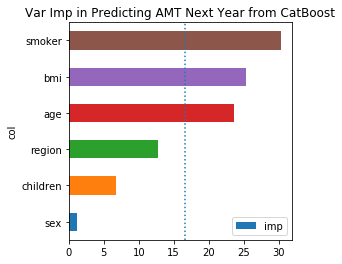

,col,imp,cum_sum_imp
4,smoker,30.41,30.41
2,bmi,25.31,55.72
0,age,23.69,79.41
5,region,12.70,92.11
3,children,6.69,98.80
1,sex,1.19,99.99
row_total,sexchildrenregionagebmismoker,99.99,NaN


In [222]:
# Mapping Feature Importance

plt.figure()
fea_imp = pd.DataFrame({'imp': cbmodel.feature_importances_, 'col': trainX.columns})
fea_imp['imp'] = round(fea_imp.imp, 2)
mean_vimp = fea_imp.imp.mean()
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(4, 4))
plt.title('Var Imp in Predicting AMT Next Year from CatBoost')
plt.axvline(mean_vimp, linestyle=':')
plt.show()

fea_imp1 = fea_imp.sort_values('imp', ascending=False)

# add row total
fea_imp1['cum_sum_imp']= round(fea_imp1['imp'].cumsum(),2)
fea_imp1.loc['row_total'] = fea_imp.apply(lambda x: x.sum())
fea_imp1

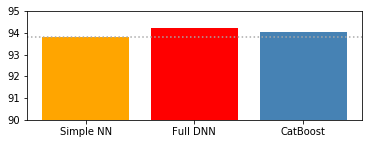

In [277]:
# accuracy comparison

mdl_nm = ['Simple NN', 'Full DNN', 'CatBoost']
mdl_accuracy = [ 93.83,  94.21, 94.03] 

colors = ['orange', 'red', 'steelblue']

plt.figure(figsize=(6,2))
plt.bar(mdl_nm, mdl_accuracy,
        color=colors)
plt.ylim(90,95)
plt.axhline(np.min(mdl_accuracy), color='darkgrey', linestyle=":")
plt.show()

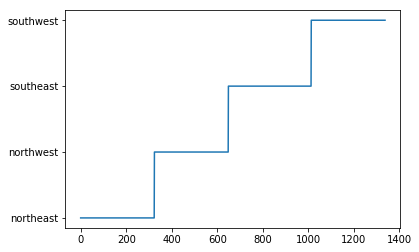

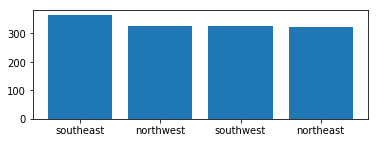

In [296]:
# check distribution of categorical variable "region"
plt.plot(np.sort(dfi01.region))
plt.show()

# alternatively
plt.figure(figsize=(6,2))
plt.bar(dfi01.region.value_counts().to_frame().index, 
        dfi01.region.value_counts().to_frame().region)
plt.show()

- region이 상당한 중요도를 가진 변수를 사실을 파악했다면 DNN에도 추가로 투입?
- region은 catgory 변수이므로 encoding !

In [303]:
# Ecoding Resion using OneHotEncoder

# import preprocessing from sklearn
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder()

# FIT
arr = np.array(dfi01['region']).reshape(-1, 1)
enc.fit(arr)

# Transform
onehotlabels = enc.transform(arr).toarray()
print(onehotlabels.shape)

ohn_region = pd.DataFrame(onehotlabels)
ohn_region.columns = ['is_SE', 'is_NW', 'is_SW', 'is_NE']
ohn_region.head()


(1338, 4)


,is_SE,is_NW,is_SW,is_NE
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [308]:
dfi03 = pd.concat([dfi02, ohn_region], axis=1)
dfi03.head()

,age,is_female,bmi,children,is_smoker,charges,is_SE,is_NW,is_SW,is_NE
0,19,1,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


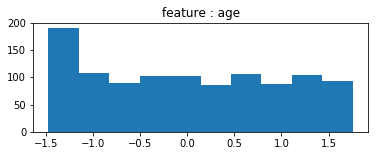

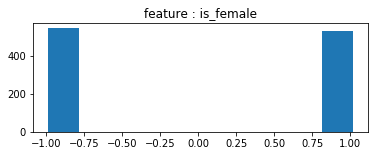

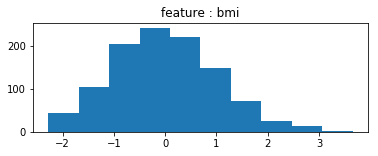

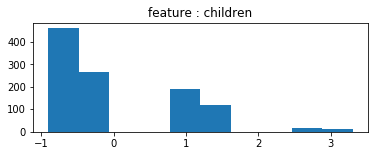

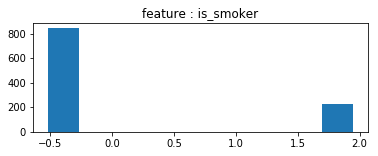

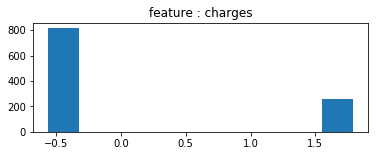

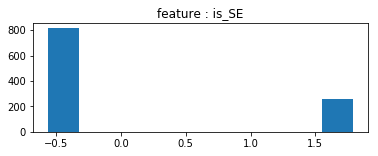

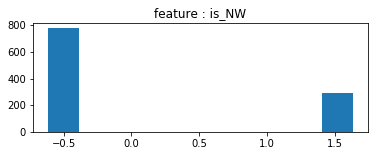

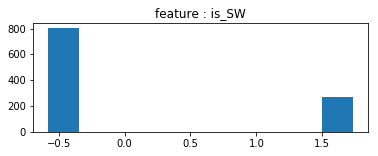

In [311]:
# [Partitioning] 

X = dfi03.drop('charges', axis=1)

# Split the data up in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


# [Scaling Inputs]

# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set based on train set distribution
X_train = scaler.transform(X_train)

# Scale the test set based on train set distribution
X_test = scaler.transform(X_test)

features_ = dfi03.ix[:,0:9].columns
# check the dstributions after scaling
for x in range(len(features_)):
    plt.figure(figsize=(6,2))
    plt.hist(X_train[:,x])
    title = 'feature : ' + features_[x]
    plt.title(title)
    plt.show()
    

In [312]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(9, activation='relu', input_shape=(9,)))

num_layers = 5
nnode = 512

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='relu')) # activation = ['sigmoid', 'relu']
    model.add(Dropout(0.5))
    node = int(nnode/2)

# Add an output layer 
model.add(Dense(1,  activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_103 (Dense)            (None, 512)               5120      
_________________________________________________________________
dropout_34 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
__________

In [317]:
# fitting (training) DNN

import datetime

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=40, batch_size=16,
                    verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()


start :  2019-10-22 14:50:01.637744
Train on 856 samples, validate on 214 samples
Epoch 1/40
856/856 [==============================] - 5s 5ms/step - loss: 0.2077 - acc: 0.9486 - val_loss: 0.8235 - val_acc: 0.9252
Epoch 2/40
856/856 [==============================] - 1s 2ms/step - loss: 0.1667 - acc: 0.9463 - val_loss: 0.8290 - val_acc: 0.9112
Epoch 3/40
856/856 [==============================] - 1s 2ms/step - loss: 0.1905 - acc: 0.9486 - val_loss: 0.6786 - val_acc: 0.9159
Epoch 4/40
856/856 [==============================] - 1s 1ms/step - loss: 0.2506 - acc: 0.9404 - val_loss: 0.7689 - val_acc: 0.9019
Epoch 5/40
856/856 [==============================] - 2s 2ms/step - loss: 0.1625 - acc: 0.9428 - val_loss: 0.7838 - val_acc: 0.9112
Epoch 6/40
856/856 [==============================] - 2s 2ms/step - loss: 0.1597 - acc: 0.9498 - val_loss: 0.8007 - val_acc: 0.9065
Epoch 7/40
856/856 [==============================] - 2s 2ms/step - loss: 0.1415 - acc: 0.9474 - val_loss: 0.7673 - val_acc: 0

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


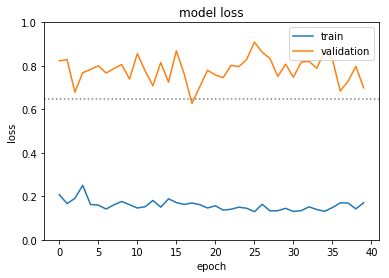

range of prediction :  0.0 1.0
1070/1070 [==============================] - 0s 173us/step

Accuracy: 94.02

Confusion Matrix : 
 [[847   1]
 [ 63 159]]


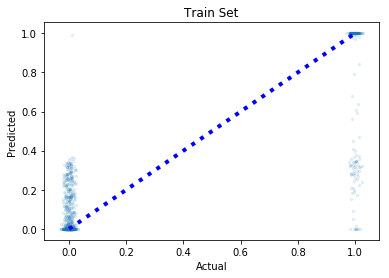

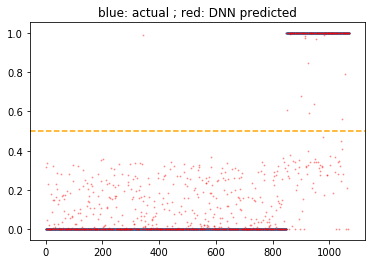

train actual and predicted corr =  0.84673
MAE =  0.09685

r_sqrd =  0.717


---


range of prediction :  0.0 1.0
268/268 [==============================] - 0s 235us/step

Accuracy: 95.52
AUC: 0.901


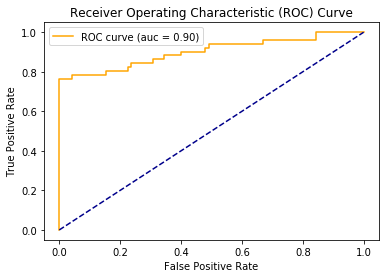


Confusion Matrix : 
 [[217   0]
 [ 12  39]]


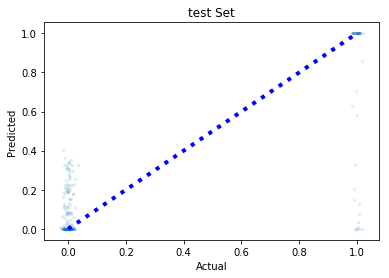

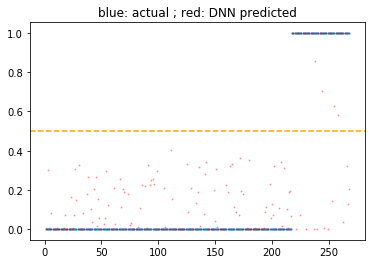

test actual and predicted corr =  0.8096
MAE =  0.10181

r_sqrd =  0.653


In [318]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


y_train_pred = model.predict(X_train)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())

# evaluate model :: check accuracy
_, accuracy = model.evaluate(X_train, y_train)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics
y_train_pred_cl = np.where(y_train_pred>=0.5,1,0)
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred_cl)
print('\nConfusion Matrix : \n', cnf_matrix)

#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train), y_train_pred, alpha=0.1, s=5)
ax.plot([y_train.min(), 1], [y_train.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print("\n\n---\n\n")


y_test_pred = model.predict(X_test)
# y_test_pred = np.where(y_test_pred <0, 0, y_test_pred)
# y_test_pred = np.where(y_test_pred >1, 1, y_test_pred)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())

# evaluate model :: check accuracy
_, accuracy = model.evaluate(X_test, y_test)
print('\nAccuracy: %.2f' % (accuracy*100))


auc = roc_auc_score(y_test, y_test_pred)
print('AUC: %.3f' % auc)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (auc = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)    
plot_roc_curve(fpr, tpr)



# import the metrics class
from sklearn import metrics
y_test_pred_cl = np.where(y_test_pred>=0.5,1,0)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred_cl)
print('\nConfusion Matrix : \n', cnf_matrix)

#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test), y_test_pred, alpha=0.1, s=5)
ax.plot([y_test.min(), 1], [y_test.min(), 1], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()


dftmp_res = pd.DataFrame({'y_actual': y_test, 
              'y_pred': np.reshape(y_test_pred,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.axhline(0.5, color='orange', linestyle='--')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(y_test, np.reshape(y_test_pred,len(y_test)))[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE,5))

from sklearn.metrics import r2_score
print('\nr_sqrd = ', round(r2_score(y_test, np.reshape(y_test_pred,len(y_test))),3))


- [생각해볼 것] train accuracy 보다 test accuracy가 높은데 , .... accuracy가 향상된 것으로 볼 수 있을까?

### [실습] Credit Card Default Prediction
dfcr01 = pd.read_csv(dataPath + 'UCI_credit_card.csv')

### For Regression - Loading [Virtual] Customer Transaction Dataset 

In [321]:
dfm01 = pd.read_csv(dataPath + 'dfc20bs.csv')
dfm01.head()

,Unnamed: 0,custid,age,sex,marital,area,education,amt_nike,amt_hnm,amt_strbk,...,amt_book,amt_htl,amt_prmmsneakers,amt_food,amt_beauty,cnt_pstyr,amt_pstyr,cnt_login,amt_nxtyr,cnt_nxtyr
0,0,1,27,F,single,SEOL,university,25100,0,20000,...,0,0,0,182.744231,24400,4,209321.0,15,185921,3
1,1,2,28,F,single,SEOL,university,21500,0,21700,...,0,0,0,43507.134000,23500,3,188514.0,17,271796,8
2,2,3,27,F,single,SEOL,university,0,0,20200,...,0,0,0,194.922917,25200,2,206183.0,16,369348,3
3,3,4,27,F,single,SEOL,college,0,0,0,...,0,0,0,121.457143,27000,2,226851.0,10,387005,8
4,4,5,27,F,single,SEOL,university,20100,0,34000,...,0,0,76700,267.888462,24600,4,221491.0,22,204884,10


### EDA - 데이터 기본 특성 파악

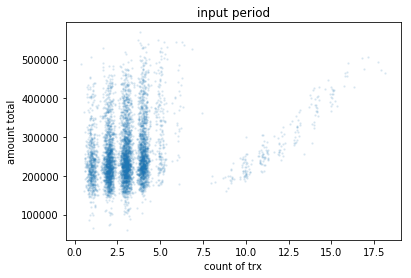

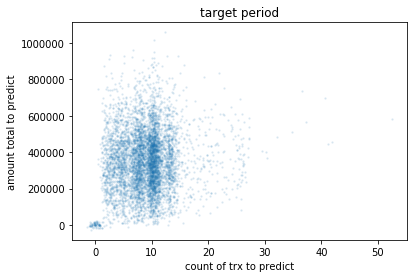

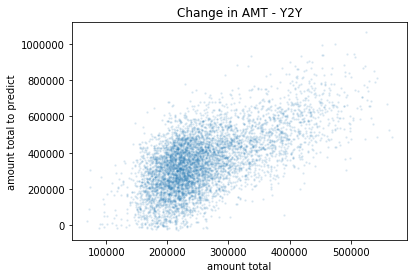

corr =  0.6261566670790368


In [322]:
# Check the distribution of the target first

plt.scatter(rjitt(dfm01.cnt_pstyr), rjitt(dfm01.amt_pstyr), s=2, alpha=0.1)
plt.title('input period')
plt.xlabel('count of trx')
plt.ylabel('amount total')
plt.show()

plt.scatter(rjitt(dfm01.cnt_nxtyr), rjitt(dfm01.amt_nxtyr), s=2, alpha=0.1)
plt.title('target period')
plt.xlabel('count of trx to predict')
plt.ylabel('amount total to predict')
plt.show()

plt.scatter(rjitt(dfm01.amt_pstyr), rjitt(dfm01.amt_nxtyr), s=2, alpha=0.1)
plt.title('Change in AMT - Y2Y')
plt.xlabel('amount total')
plt.ylabel('amount total to predict')
plt.show()

print('corr = ', np.corrcoef(dfm01.amt_pstyr, dfm01.amt_nxtyr)[0,1])

In [4]:
print(dfm01.columns)

# ['amt_nxtyr', 'cnt_nxtyr'] 미래 시점의 변수이므로 잠재적인 Target to predict

Index(['Unnamed: 0', 'custid', 'age', 'sex', 'marital', 'area', 'education',
       'amt_nike', 'amt_hnm', 'amt_strbk', 'amt_dgt', 'amt_book', 'amt_htl',
       'amt_prmmsneakers', 'amt_food', 'amt_beauty', 'cnt_pstyr', 'amt_pstyr',
       'cnt_login', 'amt_nxtyr', 'cnt_nxtyr'],
      dtype='object')


In [323]:
# 5천명의 여성고객에 한정해서 분석 실시 

dfm02 = dfm01[dfm01.sex=='F'][['custid',  'age',
                               'amt_nike', 'amt_hnm', 'amt_strbk', 'amt_dgt', 'amt_book', 'amt_htl',
                               'amt_prmmsneakers', 'amt_food', 'amt_beauty', 'cnt_pstyr', 'amt_pstyr',
                               'cnt_login', 'amt_nxtyr', 'cnt_nxtyr']]
print(dfm02.shape)
dfm02.head()

(5000, 16)


,custid,age,amt_nike,amt_hnm,amt_strbk,amt_dgt,amt_book,amt_htl,amt_prmmsneakers,amt_food,amt_beauty,cnt_pstyr,amt_pstyr,cnt_login,amt_nxtyr,cnt_nxtyr
0,1,27,25100,0,20000,0,0,0,0,182.744231,24400,4,209321.0,15,185921,3
1,2,28,21500,0,21700,0,0,0,0,43507.134000,23500,3,188514.0,17,271796,8
2,3,27,0,0,20200,0,0,0,0,194.922917,25200,2,206183.0,16,369348,3
3,4,27,0,0,0,0,0,0,0,121.457143,27000,2,226851.0,10,387005,8
4,5,27,20100,0,34000,0,0,0,76700,267.888462,24600,4,221491.0,22,204884,10


In [324]:
print(dfm02.ix[:,1:14].shape)
features_ = dfm02.ix[:,1:14].columns
features_

(5000, 13)


Index(['age', 'amt_nike', 'amt_hnm', 'amt_strbk', 'amt_dgt', 'amt_book',
       'amt_htl', 'amt_prmmsneakers', 'amt_food', 'amt_beauty', 'cnt_pstyr',
       'amt_pstyr', 'cnt_login'],
      dtype='object')

In [325]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=dfm02.ix[:,1:14]
print(dfm02.ix[:,1:14].head(3))

# Specify the target 
# 미래 1년간의 구매건수(cnt_nxtyr) 를 Target으로 설정
# y=np.ravel(np.where(dfm02.cnt_nxtyr==0, abs(rjitt(dfm02.cnt_nxtyr)), dfm02.cnt_nxtyr))
y=np.ravel(dfm02.amt_nxtyr)

# [Partitioning] Split the data up in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 아웃라이어 대비한 처리
y_max = np.percentile(y_train, 99.5)
y_train = np.where(y_train>y_max, y_max, y_train)
y_train = y_train/y_max
y_test = np.where(y_test>y_max, y_max, y_test)
y_test = y_test/y_max

   age  amt_nike  amt_hnm  amt_strbk  amt_dgt  amt_book  amt_htl  \
0   27     25100        0      20000        0         0        0   
1   28     21500        0      21700        0         0        0   
2   27         0        0      20200        0         0        0   

   amt_prmmsneakers      amt_food  amt_beauty  cnt_pstyr  amt_pstyr  cnt_login  
0                 0    182.744231       24400          4   209321.0         15  
1                 0  43507.134000       23500          3   188514.0         17  
2                 0    194.922917       25200          2   206183.0         16  


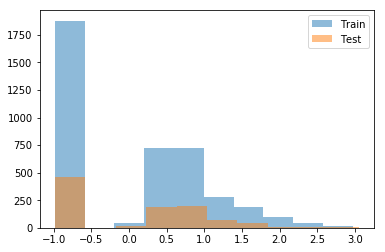

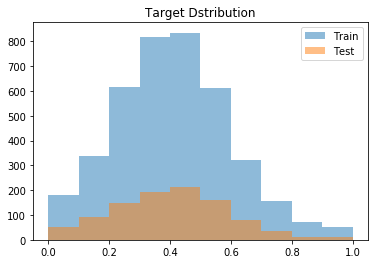

In [326]:
# [Scaling]

# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set based on train set distribution
X_train = scaler.transform(X_train)

# Scale the test set based on train set distribution
X_test = scaler.transform(X_test)


# check the dstributions after scaling
plt.hist(X_train[:,9], alpha=0.5)
plt.hist(X_test[:,9], alpha=0.5)
plt.legend(['Train','Test'])
plt.show()

# check the dstributions after scaling
plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.title('Target Dstribution')
plt.legend(['Train','Test'])
plt.show()

[ a DNN reference from datacamp ] (https://www.datacamp.com/community/tutorials/deep-learning-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t2&utm_creative=278443377086&utm_targetid=aud-299261629574:dsa-473406573755&utm_loc_interest_ms=&utm_loc_physical_ms=1009871&gclid=CjwKCAjw-vjqBRA6EiwAe8TCk2BLxXla9aXY0oBkrcxhKB0s_lfEFe0okbC0Z8JcxLMm88yyI0X2jBoCeTcQAvD_BwE )

### very simple DNN

In [327]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
# import dropout
from keras.layers import Dropout
from keras import regularizers

# Initialize the constructor
model = Sequential()


# Add an input layer 
model.add(Dense(13, activation='linear', input_shape=(13,)))

num_layers = 1 # [1, 2, 6]
nnode =4 # [2, 4, 8, 16, 32, 64]

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='linear')) # activation = ['linear', 'sigmoid', 'relu']

# Add an output layer 
model.add(Dense(1,  activation='linear'))

# Got to fit section !!

In [329]:
# fitting (training) DNN
import datetime
from keras import optimizers

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

start_time = datetime.datetime.now()
print('start : ', start_time )

history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2019-10-22 15:00:28.489462
Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 3s 895us/step - loss: 0.0221 - mean_absolute_error: 0.1192 - val_loss: 0.0224 - val_mean_absolute_error: 0.1223
Epoch 2/200
3200/3200 [==============================] - 0s 87us/step - loss: 0.0220 - mean_absolute_error: 0.1188 - val_loss: 0.0220 - val_mean_absolute_error: 0.1222
Epoch 3/200
3200/3200 [==============================] - 0s 84us/step - loss: 0.0221 - mean_absolute_error: 0.1195 - val_loss: 0.0221 - val_mean_absolute_error: 0.1213
Epoch 4/200
3200/3200 [==============================] - 0s 78us/step - loss: 0.0220 - mean_absolute_error: 0.1188 - val_loss: 0.0214 - val_mean_absolute_error: 0.1205
Epoch 5/200
3200/3200 [==============================] - 0s 82us/step - loss: 0.0218 - mean_absolute_error: 0.1185 - val_loss: 0.0219 - val_mean_absolute_error: 0.1208
Epoch 6/200
3200/3200 [==============================] - 0s 76us/step - loss

3200/3200 [==============================] - 0s 80us/step - loss: 0.0220 - mean_absolute_error: 0.1191 - val_loss: 0.0215 - val_mean_absolute_error: 0.1200
Epoch 50/200
3200/3200 [==============================] - 0s 84us/step - loss: 0.0220 - mean_absolute_error: 0.1187 - val_loss: 0.0220 - val_mean_absolute_error: 0.1221
Epoch 51/200
3200/3200 [==============================] - 0s 75us/step - loss: 0.0219 - mean_absolute_error: 0.1187 - val_loss: 0.0217 - val_mean_absolute_error: 0.1205
Epoch 52/200
3200/3200 [==============================] - 0s 69us/step - loss: 0.0219 - mean_absolute_error: 0.1189 - val_loss: 0.0216 - val_mean_absolute_error: 0.1207
Epoch 53/200
3200/3200 [==============================] - 0s 68us/step - loss: 0.0218 - mean_absolute_error: 0.1184 - val_loss: 0.0218 - val_mean_absolute_error: 0.1212
Epoch 54/200
3200/3200 [==============================] - 0s 78us/step - loss: 0.0217 - mean_absolute_error: 0.1179 - val_loss: 0.0221 - val_mean_absolute_error: 0.1213

3200/3200 [==============================] - 0s 84us/step - loss: 0.0217 - mean_absolute_error: 0.1179 - val_loss: 0.0216 - val_mean_absolute_error: 0.1210
Epoch 98/200
3200/3200 [==============================] - 0s 71us/step - loss: 0.0217 - mean_absolute_error: 0.1182 - val_loss: 0.0213 - val_mean_absolute_error: 0.1197
Epoch 99/200
3200/3200 [==============================] - 0s 65us/step - loss: 0.0217 - mean_absolute_error: 0.1181 - val_loss: 0.0213 - val_mean_absolute_error: 0.1197
Epoch 100/200
3200/3200 [==============================] - 0s 66us/step - loss: 0.0218 - mean_absolute_error: 0.1185 - val_loss: 0.0214 - val_mean_absolute_error: 0.1200
Epoch 101/200
3200/3200 [==============================] - 0s 70us/step - loss: 0.0217 - mean_absolute_error: 0.1183 - val_loss: 0.0215 - val_mean_absolute_error: 0.1205
Epoch 102/200
3200/3200 [==============================] - 0s 69us/step - loss: 0.0218 - mean_absolute_error: 0.1184 - val_loss: 0.0217 - val_mean_absolute_error: 0.1

3200/3200 [==============================] - 0s 71us/step - loss: 0.0217 - mean_absolute_error: 0.1181 - val_loss: 0.0213 - val_mean_absolute_error: 0.1199
Epoch 146/200
3200/3200 [==============================] - 0s 75us/step - loss: 0.0217 - mean_absolute_error: 0.1181 - val_loss: 0.0217 - val_mean_absolute_error: 0.1209
Epoch 147/200
3200/3200 [==============================] - 0s 66us/step - loss: 0.0216 - mean_absolute_error: 0.1180 - val_loss: 0.0219 - val_mean_absolute_error: 0.1215
Epoch 148/200
3200/3200 [==============================] - 0s 79us/step - loss: 0.0216 - mean_absolute_error: 0.1181 - val_loss: 0.0220 - val_mean_absolute_error: 0.1219
Epoch 149/200
3200/3200 [==============================] - 0s 76us/step - loss: 0.0218 - mean_absolute_error: 0.1185 - val_loss: 0.0216 - val_mean_absolute_error: 0.1207
Epoch 150/200
3200/3200 [==============================] - 0s 84us/step - loss: 0.0218 - mean_absolute_error: 0.1185 - val_loss: 0.0215 - val_mean_absolute_error: 0

3200/3200 [==============================] - 0s 68us/step - loss: 0.0216 - mean_absolute_error: 0.1179 - val_loss: 0.0216 - val_mean_absolute_error: 0.1209
Epoch 194/200
3200/3200 [==============================] - 0s 71us/step - loss: 0.0216 - mean_absolute_error: 0.1180 - val_loss: 0.0219 - val_mean_absolute_error: 0.1216
Epoch 195/200
3200/3200 [==============================] - 0s 80us/step - loss: 0.0217 - mean_absolute_error: 0.1182 - val_loss: 0.0213 - val_mean_absolute_error: 0.1199
Epoch 196/200
3200/3200 [==============================] - 0s 88us/step - loss: 0.0216 - mean_absolute_error: 0.1179 - val_loss: 0.0216 - val_mean_absolute_error: 0.1204
Epoch 197/200
3200/3200 [==============================] - 0s 69us/step - loss: 0.0217 - mean_absolute_error: 0.1181 - val_loss: 0.0218 - val_mean_absolute_error: 0.1212
Epoch 198/200
3200/3200 [==============================] - 0s 84us/step - loss: 0.0216 - mean_absolute_error: 0.1180 - val_loss: 0.0214 - val_mean_absolute_error: 0

dict_keys(['loss', 'val_loss', 'val_mean_absolute_error', 'mean_absolute_error'])
min 1% validation loss(MSE) :  0.021145316283032296


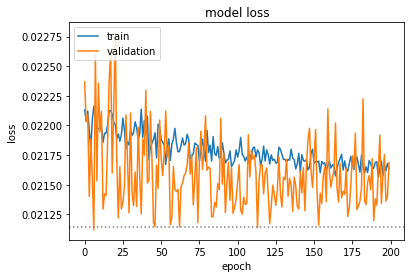

range of train set :  0.0 1.0
range of prediction :  0.084101506 0.8826132


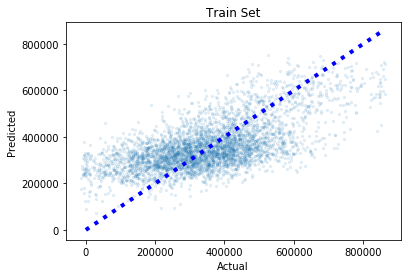

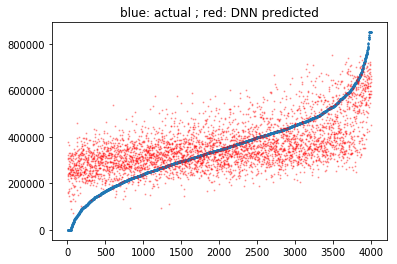

train actual and predicted corr =  0.63795
MAE =  100731.03975  ; MAE/Median =  0.29227
MdAE =  84765.49773  ; MdAE/Median =  0.24594

r_sqrd =  0.403


 ... 
range of test set :  0.0 1.0
range of prediction :  0.16146132 0.8732203


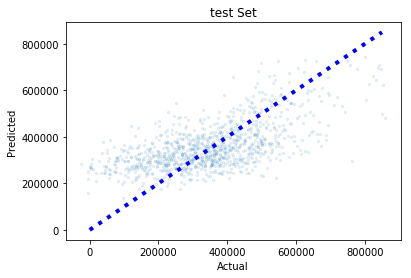

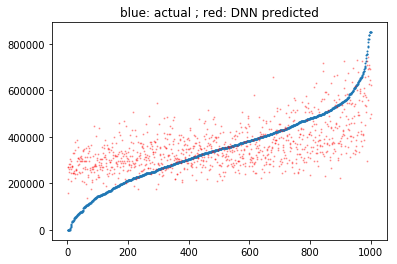

test actual and predicted corr =  0.62455
MAE =  101408.46914  ; MAE/Median =  0.29224
MdAE =  86526.68014  ; MdAE/Median =  0.24935

r_sqrd =  0.384


In [330]:
from sklearn.metrics import r2_score

print(history.history.keys())
print('min 1% validation loss(MSE) : ', np.percentile(history.history['val_loss'],1))

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


print('range of train set : ', y_train.min(), y_train.max())

y_train_pred = model.predict(X_train)
y_train_pred = np.where(y_train_pred <0, 0, y_train_pred)
y_train_pred = np.where(y_train_pred >1, 1, y_train_pred)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train*y_max), y_train_pred*y_max, alpha=0.1, s=5)
# ax.plot([y_train.min(), y_train.max()], [y_train_pred.min(), y_train_pred.max()], 'k:', lw=4)
max_range = y_max
ax.plot([y_train.min(), max_range], [y_train.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred*y_max,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual*y_max, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE*y_max,5), ' ; MAE/Median = ', round(val_MAE*y_max/np.median(y_train*y_max),5))
val_MdAE = np.median(abs(y_train - np.reshape(y_train_pred,len(y_train))))
print('MdAE = ', round(val_MdAE*y_max,5), ' ; MdAE/Median = ', round(val_MdAE*y_max/np.median(y_train*y_max),5))

print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print('\n\n ... ')



#---------- CHECKing TEST SET result ---------------

print('range of test set : ', y_test.min(), y_test.max())

y_test_pred = model.predict(X_test)
y_test_pred = np.where(y_test_pred <0, 0, y_test_pred)
y_test_pred = np.where(y_test_pred >1, 1, y_test_pred)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test*y_max), y_test_pred*y_max, alpha=0.1, s=5)
# ax.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k:', lw=4)
max_range = y_max
ax.plot([y_test.min(), max_range], [y_test.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_test*y_max, 
              'y_pred': np.reshape(y_test_pred*y_max,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(dftmp_res.y_actual, dftmp_res.y_pred)[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE*y_max,5), ' ; MAE/Median = ', round(val_MAE*y_max/np.median(y_test*y_max),5))
val_MdAE = np.median(abs(y_test - np.reshape(y_test_pred,len(y_test))))
print('MdAE = ', round(val_MdAE*y_max,5), ' ; MdAE/Median = ', round(val_MdAE*y_max/np.median(y_test*y_max),5))

print('\nr_sqrd = ', round(r2_score(dftmp_res.y_actual, dftmp_res.y_pred),3))
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)

- [a jupyter notebook tip] ctrl + / after select lines ==> comment out at once

### Bigger DNN
- [LOSS] At the most basic level, a loss function quantifies how “good” or “bad” a given predictor is at classifying the input data points in a dataset.

We, therefore, seek to:

Drive our loss down, thereby improving our model accuracy.
Do so as fast as possible and with as little hyperparameter updates/experiments.
All without overfitting our network and modeling the training data too closely.<br>:<br>
[sorce] https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss

[ 16  28  37  45  67  72  86  96 106  95 102  80  52  42  18  16  11   7
  10   2   4   3   4   0   1] [1.6, 2.8000000000000003, 3.6999999999999997, 4.5, 6.7, 7.199999999999999, 8.6, 9.6, 10.6, 9.5, 10.2, 8.0, 5.2, 4.2, 1.7999999999999998, 1.6, 1.0999999999999999, 0.7000000000000001, 1.0, 0.2, 0.4, 0.3, 0.4, 0.0, 0.1] [0.         0.04341416 0.08682831 0.13024247 0.17365662 0.21707078
 0.26048494 0.30389909 0.34731325 0.3907274  0.43414156 0.47755572
 0.52096987 0.56438403 0.60779819 0.65121234 0.6946265  0.73804065
 0.78145481 0.82486897 0.86828312 0.91169728 0.95511143 0.99852559
 1.04193975 1.0853539 ]


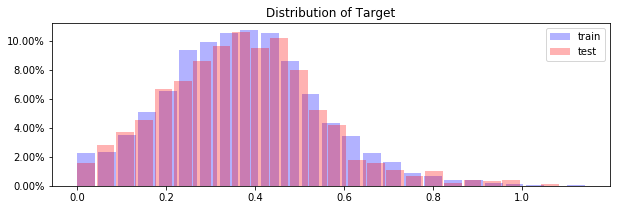

In [331]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=dfm02.ix[:,1:14]

# Specify the target 
# 미래 1년간의 구매건수(cnt_nxtyr) 를 Target으로 설정
# y=np.ravel(np.where(dfm02.cnt_nxtyr==0, abs(rjitt(dfm02.cnt_nxtyr)), dfm02.cnt_nxtyr))
y=np.ravel(dfm02.amt_nxtyr)

# scale


# [Partitioning] Split the data up in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# 아웃라이어 대비한 처리
y_max = np.percentile(y_train, 99.9)
# y_train = np.where(y_train>y_max, y_max, y_train)
y_train = y_train/y_max
# y_test = np.where(y_test>y_max, y_max, y_test)
y_test = y_test/y_max

# compare distributions
f, ax = plt.subplots(1, 1, figsize=(10,3))
heights, bins = np.histogram(y_train, bins = 25)
percent = [i/sum(heights)*100 for i in heights]
ax.bar(bins[:-1], percent, width=0.04, align="edge", color='blue', alpha=0.3)

heights, bins = np.histogram(y_test, bins = 25)
percent = [i/sum(heights)*100 for i in heights]
print(heights, percent, bins)
ax.bar(bins[:-1], percent, width=0.04, align="edge", color='red', alpha=0.3)

vals = ax.get_yticks()
ax.set_yticklabels(['%1.2f%%' %i for i in vals])
ax.legend(['train','test'])
plt.title('Distribution of Target')
plt.show()


# [Scaling]

# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

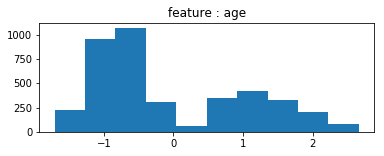

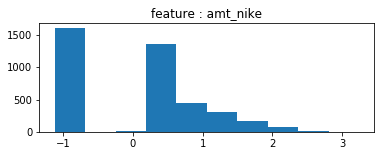

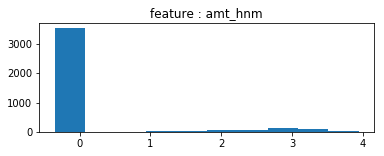

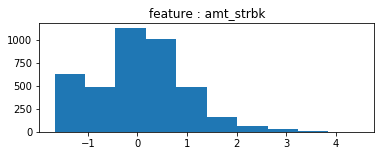

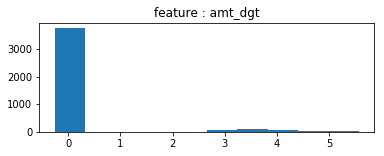

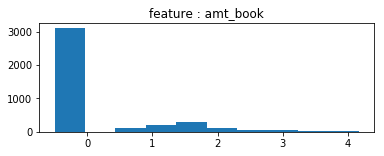

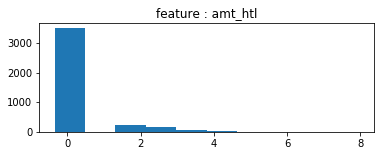

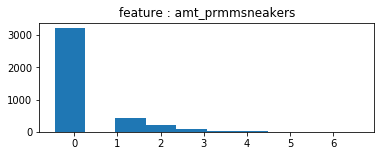

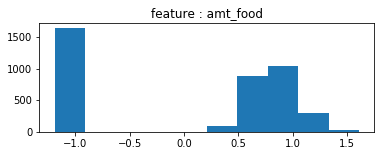

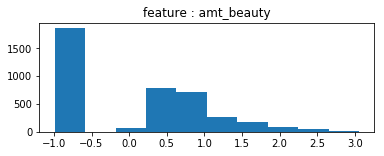

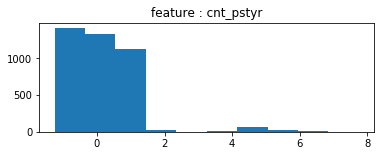

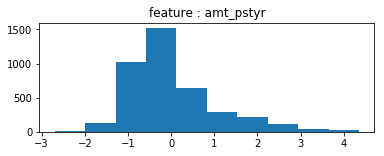

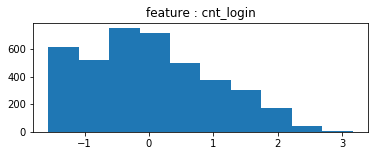

In [332]:
for x in range(13):
    plt.figure(figsize=(6,2))
    plt.hist(X_train[:,x])
    title = 'feature : ' + features_[x]
    plt.title(title)
    plt.show()

In [64]:
# Wide version

# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
# import dropout
from keras.layers import Dropout
from keras import regularizers

# Initialize the constructor
model = Sequential()

dropout_Rate = 0.3 # 0.2~0.5
actv_func4hl = 'relu'

# Add an input layer 
model.add(Dense(13, activation='linear', input_dim=13))

nlayer = 2
nnode = 256

for _ in range(nlayer):
    # Add hidden layer   
    print(nnode)
    model.add(Dense(nnode,  activation='linear' ))
    model.add(Dropout(0.2))
    # node = int(nnode/2)


# Add an output layer 
model.add(Dense(1, activation='linear'))

256
256


In [67]:
# Deep Version

from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
# import dropout
from keras.layers import Dropout
from keras import regularizers

# Initialize the constructor
model = Sequential()

dropout_Rate = 0.3 # 0.2~0.5
actv_func4hl = 'relu'

# Add an input layer 
model.add(Dense(13, activation='linear', input_dim=13))

nlayer = 6
nnode = 32

for _ in range(nlayer):
    # Add hidden layer   
    print(nnode)
    model.add(Dense(nnode,  activation='linear' ))
    model.add(Dropout(0.2))
    # node = int(nnode/2)


# Add an output layer 
model.add(Dense(1, activation='linear'))

32
32
32
32
32
32


In [335]:
# Final version

# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
# import dropout
from keras.layers import Dropout
from keras import regularizers

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(13, activation='linear', input_dim=13))

nlayer = 3
nnode = 1024

for _ in range(nlayer):
    # Add hidden layer   
    print(nnode)
    model.add(Dense(nnode,  activation='linear' ))
    model.add(Dropout(0.02))
    # node = int(nnode/2)


# Add an output layer 
model.add(Dense(1, activation='linear'))

1024
1024
1024


In [336]:
# fitting (training) DNN
from sklearn.metrics import mean_squared_error

import datetime
from keras import optimizers
from keras.optimizers import SGD, Adam

#  generally, the MAE is used in situations in which outliers can be present (Grover, 2019).
model.compile(loss='mae',
              optimizer='adam',
              metrics=['mae']) 

start_time = datetime.datetime.now()
print('strart : ', start_time )

history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    shuffle=True,
                    verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

strart :  2019-10-22 15:03:22.304267
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 12s 4ms/step - loss: 0.2994 - mean_absolute_error: 0.2994 - val_loss: 0.1302 - val_mean_absolute_error: 0.1302
Epoch 2/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1341 - mean_absolute_error: 0.1341 - val_loss: 0.1200 - val_mean_absolute_error: 0.1200
Epoch 3/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1228 - mean_absolute_error: 0.1228 - val_loss: 0.1311 - val_mean_absolute_error: 0.1311
Epoch 4/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1165 - mean_absolute_error: 0.1165 - val_loss: 0.1122 - val_mean_absolute_error: 0.1122
Epoch 5/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.1220 - val_mean_absolute_error: 0.1220
Epoch 6/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1166 - 

3200/3200 [==============================] - 9s 3ms/step - loss: 0.1097 - mean_absolute_error: 0.1097 - val_loss: 0.1081 - val_mean_absolute_error: 0.1081
Epoch 50/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.1097 - mean_absolute_error: 0.1097 - val_loss: 0.1097 - val_mean_absolute_error: 0.1097
end :  2019-10-22 15:11:22.576124
runtime :  0:08:00.271857
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 13)                182       
_________________________________________________________________
dense_113 (Dense)            (None, 1024)              14336     
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 1024)              1049600   
________________________

dict_keys(['loss', 'val_loss', 'val_mean_absolute_error', 'mean_absolute_error'])
min 1% validation loss(MSE) :  0.10812392552196978


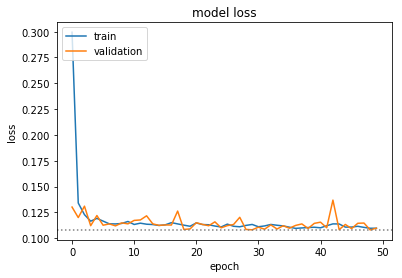

range of train set :  0.0 1.1459378853941842
range of prediction :  0.032533795 0.85156655


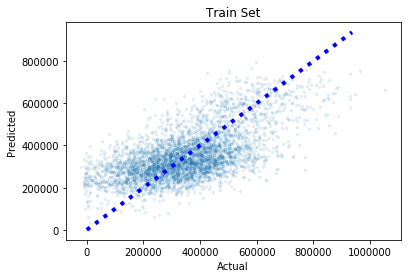

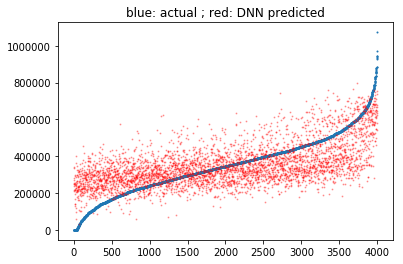

train actual and predicted corr =  0.62541
MAE =  101890.09501  ; MAE/Median =  0.29555
MdAE =  85840.79064  ; MdAE/Median =  0.249

r_sqrd =  0.384


 ... 
range of test set :  0.0 1.0853539025820491
range of prediction :  0.07763448 0.82252514


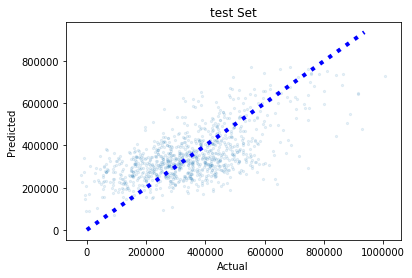

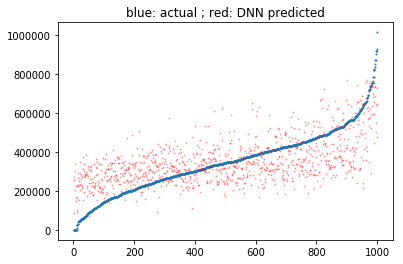

test actual and predicted corr =  0.62896
MAE =  103669.91306  ; MAE/Median =  0.30047
MdAE =  91018.93398  ; MdAE/Median =  0.26381

r_sqrd =  0.386


In [337]:
from sklearn.metrics import r2_score

print(history.history.keys())
print('min 1% validation loss(MSE) : ', np.percentile(history.history['val_loss'],1))

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


print('range of train set : ', y_train.min(), y_train.max())

y_train_pred = model.predict(X_train)
y_train_pred = np.where(y_train_pred <0, 0, y_train_pred)
y_train_pred = np.where(y_train_pred >1, 1, y_train_pred)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train*y_max), y_train_pred*y_max, alpha=0.1, s=5)
# ax.plot([y_train.min(), y_train.max()], [y_train_pred.min(), y_train_pred.max()], 'k:', lw=4)
max_range = y_max
ax.plot([y_train.min(), max_range], [y_train.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred*y_max,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual*y_max, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE*y_max,5), ' ; MAE/Median = ', round(val_MAE*y_max/np.median(y_train*y_max),5))
val_MdAE = np.median(abs(y_train - np.reshape(y_train_pred,len(y_train))))
print('MdAE = ', round(val_MdAE*y_max,5), ' ; MdAE/Median = ', round(val_MdAE*y_max/np.median(y_train*y_max),5))

print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print('\n\n ... ')



#---------- CHECKing TEST SET result ---------------

print('range of test set : ', y_test.min(), y_test.max())

y_test_pred = model.predict(X_test)
y_test_pred = np.where(y_test_pred <0, 0, y_test_pred)
y_test_pred = np.where(y_test_pred >1, 1, y_test_pred)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test*y_max), y_test_pred*y_max, alpha=0.1, s=5)
# ax.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k:', lw=4)
max_range = y_max
ax.plot([y_test.min(), max_range], [y_test.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_test*y_max, 
              'y_pred': np.reshape(y_test_pred*y_max,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(dftmp_res.y_actual, dftmp_res.y_pred)[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE*y_max,5), ' ; MAE/Median = ', round(val_MAE*y_max/np.median(y_test*y_max),5))
val_MdAE = np.median(abs(y_test - np.reshape(y_test_pred,len(y_test))))
print('MdAE = ', round(val_MdAE*y_max,5), ' ; MdAE/Median = ', round(val_MdAE*y_max/np.median(y_test*y_max),5))

print('\nr_sqrd = ', round(r2_score(dftmp_res.y_actual, dftmp_res.y_pred),3))
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)


In [ ]:
# Model = [dropout, Test MAE, Test r_sqrd]
#---------------------
# Simple Net = [0, 100478 , 0.39 ]
# Wide Net  = [0.2, 102854, 0.389 ]
# Deep Net  = [0.2, 103558 , 0.377 ]

# LR = [-, 101823, 0.406]
# RF = [-, 104739, 0.374]

# Final Net = [0.2, 103669, 0.386] # without extreme value replacement


https://www.kaggle.com/xgdbigdata/keras-regression-tutorial  # 리그레션 튜토리얼 체크!!

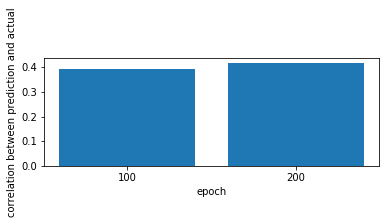

In [59]:
plt.figure(figsize=(6,2))
plt.bar(np.array([100,200]).astype(str), [0.39064,0.41615 ])
plt.xlabel('epoch')
plt.ylabel('correlation between prediction and actual')
plt.show()

### Run Other techniques to compare  - Exploratory Baseline Modeling

Intercept:   34797.66420619277
Coefficients:   [-2.20447512e+03 -2.10252955e-01  7.62643011e-02  1.90055964e+00
 -1.03552463e-01 -7.70500477e-01 -4.03527421e-02  5.75047105e-02
 -1.13653561e-01 -2.20717189e-01 -6.08207766e+02  1.38707479e+00
 -1.72975178e+02]
range of train set :  0 1072889
range of prediction :  75855.62243359671 742688.5931235356


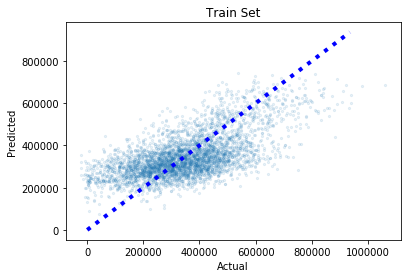

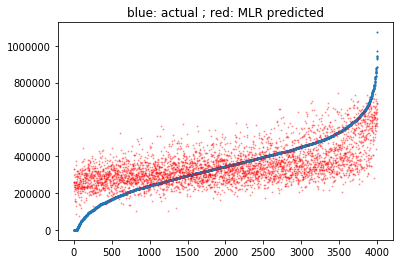

train actual and predicted corr =  0.63709
MAE =  100301.56677  ; MAE/Median =  0.29094
MdAE =  83967.4343  ; MdAE/Median =  0.24356

r_sqrd =  0.406


 ... 
range of test set :  0 1016167
range of prediction :  109174.82736962428 721749.6081204212


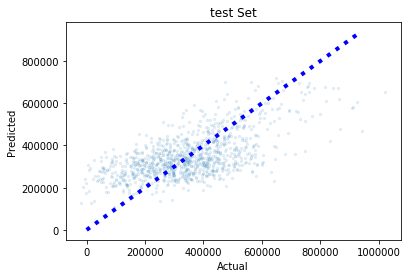

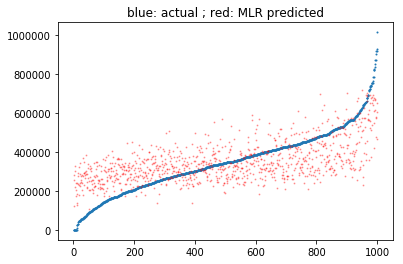

test actual and predicted corr =  0.63755
MAE =  101823.5262  ; MAE/Median =  0.29512
MdAE =  88480.94062  ; MdAE/Median =  0.25645

r_sqrd =  0.406


In [338]:
### Run Linear Regression as one of the baseline models 

from pandas import DataFrame
from sklearn import linear_model

X = dfm02[['age', 'amt_nike', 'amt_hnm', 'amt_strbk', 'amt_dgt', 'amt_book',
       'amt_htl', 'amt_prmmsneakers', 'amt_food', 'amt_beauty', 'cnt_pstyr',
       'amt_pstyr', 'cnt_login']] 
y = dfm02['amt_nxtyr']
 
    
# [Partitioning] Split the data up in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Intercept:  ', regr.intercept_)
print('Coefficients:  ', regr.coef_)



from sklearn.metrics import r2_score

print('range of train set : ', y_train.min(), y_train.max())

y_train_pred = regr.predict(X_train)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train), y_train_pred, alpha=0.1, s=5)
max_range = y_max
ax.plot([y_train.min(), max_range], [y_train.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()



dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: MLR predicted')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE,5), ' ; MAE/Median = ', round(val_MAE/np.median(y_train),5))
val_MdAE = np.median(abs(y_train - np.reshape(y_train_pred,len(y_train))))
print('MdAE = ', round(val_MdAE,5), ' ; MdAE/Median = ', round(val_MdAE/np.median(y_train),5))

print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print('\n\n ... ')


#----------
# CHECK TEST SET result

print('range of test set : ', y_test.min(), y_test.max())

y_test_pred = regr.predict(X_test)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test), y_test_pred, alpha=0.1, s=5)
max_range = y_max
ax.plot([y_test.min(), max_range], [y_test.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_test, 
              'y_pred': np.reshape(y_test_pred,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: MLR predicted')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(dftmp_res.y_actual, dftmp_res.y_pred)[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE,5), ' ; MAE/Median = ', round(val_MAE/np.median(y_test),5))
val_MdAE = np.median(abs(y_test - np.reshape(y_test_pred,len(y_test))))
print('MdAE = ', round(val_MdAE,5), ' ; MdAE/Median = ', round(val_MdAE/np.median(y_test),5))

print('\nr_sqrd = ', round(r2_score(dftmp_res.y_actual, dftmp_res.y_pred),3))
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)




### Overfitting and Underfitting
the most common ways to prevent overfitting in neural networks:
* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

### comparison : RF

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r-squared : 0.9138417287448583
range of train set :  0 1072889
range of prediction :  35440.311 949856.778


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


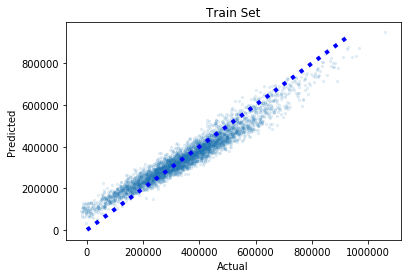

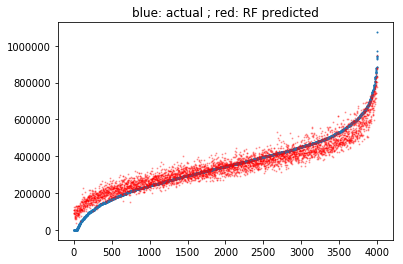

train actual and predicted corr =  0.96997
MAE =  37980.93039  ; MAE/Median =  0.11017
MdAE =  31708.99  ; MdAE/Median =  0.09198

r_sqrd =  0.914


 ... 
range of test set :  0 1016167


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


range of prediction :  90036.749 795824.404


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


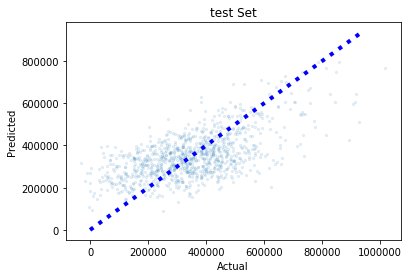

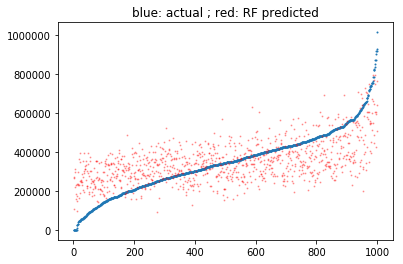

test actual and predicted corr =  0.61261
MAE =  104739.62443  ; MAE/Median =  0.30357
MdAE =  90219.492  ; MdAE/Median =  0.26149

r_sqrd =  0.374


In [223]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=1000, random_state=99,
                                  oob_score=True, verbose=1)
regressor.fit(X_train, y_train)
print('r-squared :', regressor.score(X_train, y_train, sample_weight=None))


from sklearn.metrics import r2_score

print('range of train set : ', y_train.min(), y_train.max())

y_train_pred = regressor.predict(X_train)
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


#  check distribution of prediction -- train set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_train), y_train_pred, alpha=0.1, s=5)
max_range = y_max
ax.plot([y_train.min(), max_range], [y_train.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Train Set')
plt.show()



dftmp_res = pd.DataFrame({'y_actual': y_train, 
              'y_pred': np.reshape(y_train_pred,len(y_train))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_train)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: RF predicted')
plt.show()

print('train actual and predicted corr = ' , round(np.corrcoef(y_train, np.reshape(y_train_pred,len(y_train)))[0][1],5 ))

val_MAE = abs(y_train - np.reshape(y_train_pred,len(y_train))).mean()
print('MAE = ', round(val_MAE,5), ' ; MAE/Median = ', round(val_MAE/np.median(y_train),5))
val_MdAE = np.median(abs(y_train - np.reshape(y_train_pred,len(y_train))))
print('MdAE = ', round(val_MdAE,5), ' ; MdAE/Median = ', round(val_MdAE/np.median(y_train),5))

print('\nr_sqrd = ', round(r2_score(y_train, np.reshape(y_train_pred,len(y_train))),3))

print('\n\n ... ')


#----------
# CHECK TEST SET result

print('range of test set : ', y_test.min(), y_test.max())

y_test_pred = regressor.predict(X_test)
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


#  check distribution of prediction -- test set

fig, ax = plt.subplots()
ax.scatter(rjitt(y_test), y_test_pred, alpha=0.1, s=5)
max_range = y_max
ax.plot([y_test.min(), max_range], [y_test.min(), max_range], 'b:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('test Set')
plt.show()

dftmp_res = pd.DataFrame({'y_actual': y_test, 
              'y_pred': np.reshape(y_test_pred,len(y_test))})
dftmp_res = dftmp_res.sort_values('y_actual')

plt.scatter(range(1,len(y_test)+1), dftmp_res.y_actual, s=1)
plt.scatter(range(1,len(y_test)+1), dftmp_res.y_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: RF predicted')
plt.show()

print('test actual and predicted corr = ' , round(np.corrcoef(dftmp_res.y_actual, dftmp_res.y_pred)[0][1],5 ))

val_MAE = abs(y_test - np.reshape(y_test_pred,len(y_test))).mean()
print('MAE = ', round(val_MAE,5), ' ; MAE/Median = ', round(val_MAE/np.median(y_test),5))
val_MdAE = np.median(abs(y_test - np.reshape(y_test_pred,len(y_test))))
print('MdAE = ', round(val_MdAE,5), ' ; MdAE/Median = ', round(val_MdAE/np.median(y_test),5))

print('\nr_sqrd = ', round(r2_score(dftmp_res.y_actual, dftmp_res.y_pred),3))
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)



### MULTIPLE target variable case (i.e. y1 and y2)
- 하나의 모델이 한 번에 여러 타겟 변수를 예측하는 모델

In [481]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=dfm02.ix[:,1:14]
print(dfm02.ix[:,1:14].head())

# Specify the target 
y1 = np.ravel(dfm02.cnt_nxtyr)
y2 = np.ravel(dfm02.amt_nxtyr)


# Split the data up in train and test sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.33, random_state=12)

# scaling
# adjust possibly extreme values
y1_max = np.percentile(y1_train, 99.9)
y1_train = np.where(y1_train>y1_max, y1_max, y1_train)
y1_train = y1_train/y1_max

y2_max = np.percentile(y2_train, 99)
y2_train = np.where(y2_train>y2_max, y2_max, y2_train)
y2_train = y2_train/y2_max

y1_test = y1_test/y1_max
y2_test = y2_test/y2_max

y_train = np.transpose(np.array([y1_train, y2_train]))
print(X_train.shape, y_train.shape)

   age  amt_nike  amt_hnm  amt_strbk  amt_dgt  amt_book  amt_htl  \
0   27     25100        0      20000        0         0        0   
1   28     21500        0      21700        0         0        0   
2   27         0        0      20200        0         0        0   
3   27         0        0          0        0         0        0   
4   27     20100        0      34000        0         0        0   

   amt_prmmsneakers      amt_food  amt_beauty  cnt_pstyr  amt_pstyr  cnt_login  
0                 0    182.744231       24400          4   209321.0         15  
1                 0  43507.134000       23500          3   188514.0         17  
2                 0    194.922917       25200          2   206183.0         16  
3                 0    121.457143       27000          2   226851.0         10  
4             76700    267.888462       24600          4   221491.0         22  
(3350, 13) (3350, 2)


In [482]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)


In [483]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model2 = Sequential()

# Add an input layer 
model2.add(Dense(13, activation='relu', input_shape=(13,)))


nlayer = 4
nnode = 128

for _ in range(nlayer):
    # Add hidden layer   
    print(nnode)
    model2.add(Dense(nnode,  activation='relu' ))
    model2.add(Dropout(0.2))
    node = int(nnode/2)


# Add an output layer 
model2.add(Dense(2, activation='linear'))

128
128
128
128


In [484]:
import datetime

model2.compile(loss='mae',
              optimizer='adam',
              metrics=['mae'])

start_time = datetime.datetime.now()
print('strart : ', start_time )

history = model2.fit(X_train, y_train, epochs=100, batch_size=16, 
                     verbose=1, validation_split=0.2)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)

strart :  2019-10-22 17:35:21.532473
Train on 2680 samples, validate on 670 samples
Epoch 1/100
2680/2680 [==============================] - 6s 2ms/step - loss: 0.1419 - mean_absolute_error: 0.1419 - val_loss: 0.1217 - val_mean_absolute_error: 0.1217
Epoch 2/100
2680/2680 [==============================] - 2s 581us/step - loss: 0.1202 - mean_absolute_error: 0.1202 - val_loss: 0.1121 - val_mean_absolute_error: 0.1121
Epoch 3/100
2680/2680 [==============================] - 2s 665us/step - loss: 0.1171 - mean_absolute_error: 0.1171 - val_loss: 0.1087 - val_mean_absolute_error: 0.1087
Epoch 4/100
2680/2680 [==============================] - 2s 712us/step - loss: 0.1162 - mean_absolute_error: 0.1162 - val_loss: 0.1086 - val_mean_absolute_error: 0.1086
Epoch 5/100
2680/2680 [==============================] - 2s 653us/step - loss: 0.1140 - mean_absolute_error: 0.1140 - val_loss: 0.1089 - val_mean_absolute_error: 0.1089
Epoch 6/100
2680/2680 [==============================] - 2s 631us/step - 

Epoch 49/100
2680/2680 [==============================] - 2s 639us/step - loss: 0.1015 - mean_absolute_error: 0.1015 - val_loss: 0.1086 - val_mean_absolute_error: 0.1086
Epoch 50/100
2680/2680 [==============================] - 2s 647us/step - loss: 0.1015 - mean_absolute_error: 0.1015 - val_loss: 0.1065 - val_mean_absolute_error: 0.1065
Epoch 51/100
2680/2680 [==============================] - 2s 630us/step - loss: 0.1020 - mean_absolute_error: 0.1020 - val_loss: 0.1059 - val_mean_absolute_error: 0.1059
Epoch 52/100
2680/2680 [==============================] - 2s 634us/step - loss: 0.1015 - mean_absolute_error: 0.1015 - val_loss: 0.1065 - val_mean_absolute_error: 0.1065
Epoch 53/100
2680/2680 [==============================] - 2s 797us/step - loss: 0.1011 - mean_absolute_error: 0.1011 - val_loss: 0.1076 - val_mean_absolute_error: 0.1076
Epoch 54/100
2680/2680 [==============================] - 2s 726us/step - loss: 0.1005 - mean_absolute_error: 0.1005 - val_loss: 0.1078 - val_mean_abs

Epoch 97/100
2680/2680 [==============================] - 2s 646us/step - loss: 0.0947 - mean_absolute_error: 0.0947 - val_loss: 0.1098 - val_mean_absolute_error: 0.1098
Epoch 98/100
2680/2680 [==============================] - 2s 629us/step - loss: 0.0958 - mean_absolute_error: 0.0958 - val_loss: 0.1112 - val_mean_absolute_error: 0.1112
Epoch 99/100
2680/2680 [==============================] - 2s 716us/step - loss: 0.0954 - mean_absolute_error: 0.0954 - val_loss: 0.1105 - val_mean_absolute_error: 0.1105
Epoch 100/100
2680/2680 [==============================] - 2s 754us/step - loss: 0.0953 - mean_absolute_error: 0.0953 - val_loss: 0.1098 - val_mean_absolute_error: 0.1098
end :  2019-10-22 17:38:27.290319
runtime :  0:03:05.757846


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 13)                182       
_________________________________________________________________
dense_172 (Dense)            (None, 128)               1792      
_________________________________________________________________
dropout_74 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_75 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0         
__________

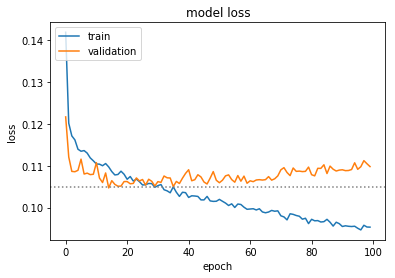

[[0.25376758 0.2811682 ]
 [0.29011345 0.47351152]
 [0.35806662 0.44963622]
 ...
 [0.2896025  0.34775418]
 [0.2977684  0.3823313 ]
 [0.28007445 0.24201515]]


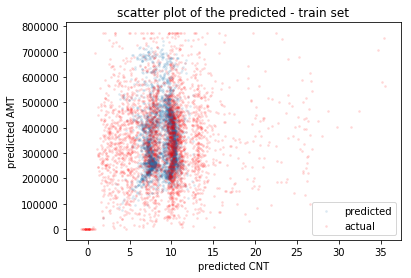

In [488]:
print(model2.summary())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



y_train_pred = model2.predict(X_train)

print(y_train_pred)

plt.scatter(y_train_pred[:,0]*y1_max, y_train_pred[:,1]*y2_max, alpha=0.1, s=3)
plt.scatter(rjitt(y1_train)*y1_max, y2_train*y2_max, alpha=0.1, s=3, color='red')
plt.title('scatter plot of the predicted - train set')
plt.xlabel('predicted CNT')
plt.ylabel('predicted AMT')
plt.legend(['predicted','actual'])
plt.show()

corr =  0.28085


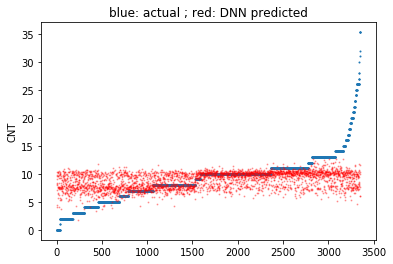

corr =  0.73722


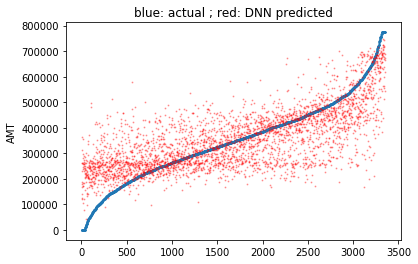

In [489]:
dftmp_res = pd.DataFrame({'y1_actual': y1_train*y1_max, 
                          'y2_actual': y2_train*y2_max, 
                          'y1_pred': np.reshape(y_train_pred[:,0],len(y_train_pred))*y1_max,
                          'y2_pred': np.reshape(y_train_pred[:,1],len(y_train_pred))*y2_max})
                         
dftmp_res1 = dftmp_res[['y1_actual','y1_pred']].sort_values('y1_actual')
print('corr = ' , round(np.corrcoef(dftmp_res1.y1_actual, dftmp_res1.y1_pred)[0][1],5 ))

plt.scatter(range(1,len(y_train)+1), dftmp_res1.y1_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res1.y1_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.ylabel('CNT')
plt.show()


dftmp_res1 = dftmp_res[['y2_actual','y2_pred']].sort_values('y2_actual')
print('corr = ' , round(np.corrcoef(dftmp_res1.y2_actual, dftmp_res1.y2_pred)[0][1],5 ))

plt.scatter(range(1,len(y_train)+1), dftmp_res1.y2_actual, s=1)
plt.scatter(range(1,len(y_train)+1), dftmp_res1.y2_pred, s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.ylabel('AMT')
plt.show()


corr =  0.12587


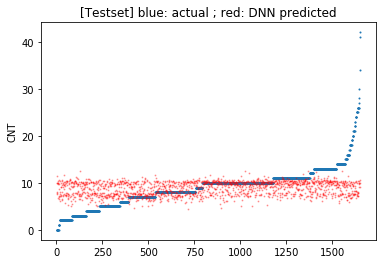

corr =  0.53353


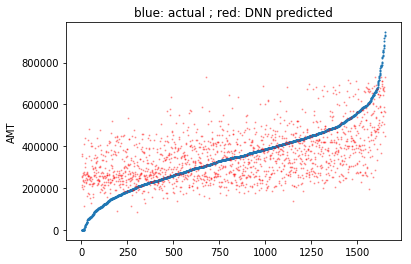

MAE =  2.9428448142427386 111786.94115530304

r_sqrd =  -0.027 0.242


In [490]:
y_test_pred = model2.predict(X_test)

dftmp_res = pd.DataFrame({'y1_actual': y1_test*y1_max, 
                          'y2_actual': y2_test*y2_max, 
                          'y1_pred': np.reshape(y_test_pred[:,0],len(y_test_pred))*y1_max,
                          'y2_pred': np.reshape(y_test_pred[:,1],len(y_test_pred))*y2_max})
                         
dftmp_res1 = dftmp_res[['y1_actual','y1_pred']].sort_values('y1_actual')

print('corr = ' , round(np.corrcoef(dftmp_res1.y1_actual, dftmp_res1.y1_pred)[0][1],5 ))

x_vals = np.array(range(1,len(y1_test)+1))
plt.scatter(x_vals , dftmp_res1.y1_actual, s=1)
plt.scatter(x_vals , rjitt(dftmp_res1.y1_pred), s=1, color='red', alpha=0.3)
plt.title('[Testset] blue: actual ; red: DNN predicted')
plt.ylabel('CNT')
plt.show()


dftmp_res1 = dftmp_res[['y2_actual','y2_pred']].sort_values('y2_actual')
print('corr = ' , round(np.corrcoef(dftmp_res1.y2_actual, dftmp_res1.y2_pred)[0][1],5 ))

x_vals = np.array(range(1,len(y2_test)+1))
plt.scatter(x_vals , dftmp_res1.y2_actual, s=1)
plt.scatter(x_vals , rjitt(dftmp_res1.y2_pred), s=1, color='red', alpha=0.3)
plt.title('blue: actual ; red: DNN predicted')
plt.ylabel('AMT')
plt.show()

print('MAE = ', abs(dftmp_res.y1_actual - dftmp_res.y1_pred).mean(), abs(dftmp_res.y2_actual - dftmp_res.y2_pred).mean())

from sklearn.metrics import r2_score

print('\nr_sqrd = ', round(r2_score(dftmp_res.y1_actual, dftmp_res.y1_pred),3),
     round(r2_score(dftmp_res.y2_actual, dftmp_res.y2_pred),3))

# CNN Convolutional NN

- CNN example ::  https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ 

### to prepare retail (REI) data for CNN

In [2]:
#--------------

df001 = pd.read_csv('C:/YONG/r_Y_B/GAMDFM/REI_retail/tb_tr01.csv')
# convert sas date to pandas date
df001['tr_date'] = (pd.to_timedelta(df001.d_date, unit='S') + pd.Timestamp('1960-1-1')).astype(str).str.slice(0, 9)
df002 = df001[['customer_id','sk_transaction_id', 'sk_item_id', 't_item_amt_sale','t_item_qty_sale', 'tr_date']]
df002 = df002[df002.customer_id>1000] 


print(df002.tr_date.min(), df002.tr_date.max())
df002.sort_values('tr_date').head()


2002-01-0 2003-12-3


,customer_id,sk_transaction_id,sk_item_id,t_item_amt_sale,t_item_qty_sale,tr_date
162260,4928473,41876257.0,72742.0,1.35,1.0,2002-01-0
173691,5272402,42024602.0,36516.0,11.95,1.0,2002-01-0
173690,5272402,42024602.0,37462.0,75.00,1.0,2002-01-0
146676,4460011,42236806.0,42140.0,8.95,1.0,2002-01-0
23627,806142,42003842.0,34042.0,20.00,1.0,2002-01-0


In [3]:
# df002.sort_values('tr_date').tail()

In [3]:
df003 = pd.read_csv('C:/YONG/r_Y_B/GAMDFM/REI_retail/sku_mast01.csv')
df003.head()
df004 = df003[['sk_item_id', 'department_name']]
df004['department_name'].drop_duplicates().head()

0    Dividend Adjustment
1      Tender Adjustment
2      Header Adjustment
3                UNKNOWN
4             FIELD GEAR
Name: department_name, dtype: object

In [4]:
df002['tr_amt_sale'] = df002.t_item_amt_sale * df002.t_item_qty_sale
df005 = df002[['customer_id','sk_transaction_id', 'sk_item_id', 'tr_date', 'tr_amt_sale']]
df006 = df005.merge(df004, on='sk_item_id', how='left' )
df006.department_name.fillna('others', inplace=True)
df006['tr_mnth'] = df006.tr_date.str.slice(0, 7)
df006 = df006[['customer_id','tr_mnth', 'tr_amt_sale', 'department_name']]
df007 = df006.groupby(['customer_id','tr_mnth','department_name']).sum().reset_index()
df007.sort_values(['customer_id','tr_mnth']).head(20)

,customer_id,tr_mnth,department_name,tr_amt_sale
0,1114,2003-05,WOMEN'S FOOTWEAR,59.99
1,1114,2003-05,others,131.86
2,2900,2002-12,TRAVEL,48.00
3,2900,2002-12,others,112.00
4,2900,2003-01,CAMPING GEAR,69.90
5,2900,2003-01,others,4.50
6,3224,2002-08,WOMENSWEAR,32.99
7,3224,2002-08,others,82.82
8,3224,2003-01,others,112.00
9,3224,2003-11,GIFTS/GAMES/GADGETS,13.00


In [5]:
df008 = df007[df007.tr_mnth.str.slice(0,4)=='2002']
df008.head()

,customer_id,tr_mnth,department_name,tr_amt_sale
2,2900,2002-12,TRAVEL,48.00
3,2900,2002-12,others,112.00
6,3224,2002-08,WOMENSWEAR,32.99
7,3224,2002-08,others,82.82
10,4860,2002-01,MEN'S FOOTWEAR,15.00


In [6]:
df0081 = df008[['customer_id','department_name']].drop_duplicates().groupby('department_name').count().reset_index()
df0081 = df0081.sort_values('customer_id', ascending=False)
df0081['dept_size_rnk'] = range(0,(df0081.shape[0]))
df0081['department_name'] = np.where(df0081['dept_size_rnk'] >11, 'others',df0081.department_name)
df0081['dept_size_rnk'] = np.where(df0081['dept_size_rnk'] >11, 0,df0081.dept_size_rnk)
df0081['dept_size_rnk'] = np.where(df0081['dept_size_rnk'] ==0, 12,df0081.dept_size_rnk)

df0081 = df0081.groupby(['department_name','dept_size_rnk']).sum().reset_index()
df0081 = df0081.sort_values('dept_size_rnk')

df0081

,department_name,dept_size_rnk,customer_id
2,CAMPING GEAR,1,4547
5,FOOD,2,2256
9,SOCKS,3,2158
8,SLEEPING BAGS,4,1516
6,MEN'S FOOTWEAR,5,1287
0,BASIC CLOTHING,6,1266
1,BIKE ACCESSORIES,7,1174
3,CLIMBING,8,1163
4,FIELD GEAR,9,1068
7,OXT/PERFORMANCEWEAR,10,890


In [7]:
df0082 = df008.merge(df0081[['department_name','dept_size_rnk']])
df0082['mnth_id'] = df0082.tr_mnth.str.slice(5,7).astype(int)

# df0082['amt'] = np.where(df0082.tr_amt_sale>0,1,0)
df0082['amt'] = np.where(df0082.tr_amt_sale<0,0,df0082.tr_amt_sale)
df0082['amt'] = np.where(df0082.amt>50,50,df0082.amt)
df0082['amt'] = df0082.amt/df0082.amt.max()
print(df0082['amt'].median())
print(df0082.shape)
df0082.sort_values(['customer_id','tr_mnth','dept_size_rnk']).head()
# df0082.to_pickle(dataPath + 'df0082.pkl')

# df0083 = []

0.67
(43573, 7)


,customer_id,tr_mnth,department_name,tr_amt_sale,dept_size_rnk,mnth_id,amt
0,2900,2002-12,TRAVEL,48.00,11,12,0.96
980,2900,2002-12,others,112.00,12,12,1.00
981,3224,2002-08,others,82.82,12,8,1.00
21077,4860,2002-01,MEN'S FOOTWEAR,15.00,5,1,0.30
982,4860,2002-01,others,323.82,12,1,1.00


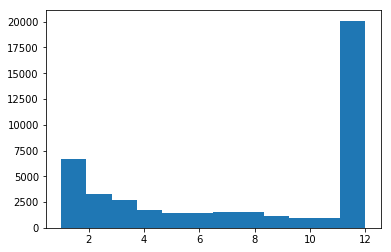

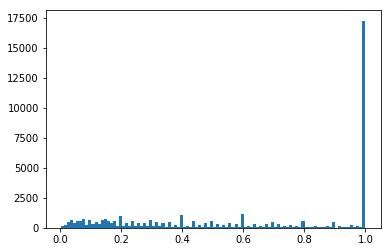

In [8]:
plt.hist(df0082.dept_size_rnk, bins=12)
plt.show()

plt.hist(df0082.amt, bins=100)
plt.show()

In [9]:
cust_list =df0082.customer_id.unique()
np.array(np.random.shuffle(cust_list))
cust_list[:10]

# shape should be in ... 
# print(train_images.shape) # (10000, 12, 12, 1)

array([4984156, 5063100, 1258545,  987874, 8786298, 3755671, 3565207,
       4089955, 8708020, 4082499], dtype=int64)

In [10]:
# create empty combination frame
from itertools import product

dfpkt = pd.DataFrame(data=list(product(df0082.dept_size_rnk.unique(), df0082.mnth_id.unique())), columns=['dept_size_rnk', 'mnth_id'])
# print(dfpkt.sort_values(['mnth_id', 'dept_size_rnk']).tail(10))
# print(dfpkt.shape, 12*12)

empty_arr =  np.zeros(shape=[1,12,12])
# print(empty_arr)

smpl_size = 8000

for x in cust_list[:smpl_size]:
    dftmp01 = df0082[df0082.customer_id==x][['mnth_id', 'dept_size_rnk','amt']]
    dftmp02 = dfpkt.merge(dftmp01, on=['mnth_id', 'dept_size_rnk'], how='left')
    dftmp02.fillna(0, inplace=True)
    # print(dftmp02.head(20))
    dftmp02 = dftmp02.pivot(values='amt', index='dept_size_rnk', columns='mnth_id').reset_index()
    dftmp02.fillna(0, inplace=True)
    atmp1 = np.array(dftmp02.iloc[:,1:]).reshape(1,12,12)
    # print(atmp1)
    empty_arr = np.concatenate((empty_arr, atmp1), axis=0)
    # print(empty_arr)
    if x in cust_list[[1000, 2000, 3000]]:
        print(x)

train_arr = empty_arr        
print(train_arr.shape)

# prepare test set
empty_arr =  np.zeros(shape=[1,12,12])
# print(empty_arr)

print('\n....... preparing test set\n')
smpl_size = smpl_size

for x in cust_list[smpl_size:]:
    dftmp01 = df0082[df0082.customer_id==x][['mnth_id', 'dept_size_rnk','amt']]
    dftmp02 = dfpkt.merge(dftmp01, on=['mnth_id', 'dept_size_rnk'], how='left')
    dftmp02.fillna(0, inplace=True)
    dftmp02 = dftmp02.pivot(values='amt', index='dept_size_rnk', columns='mnth_id').reset_index()
    dftmp02.fillna(0, inplace=True)
    atmp1 = np.array(dftmp02.iloc[:,1:]).reshape(1,12,12)
    # print(atmp1)
    empty_arr = np.concatenate((empty_arr, atmp1), axis=0)
    # print(empty_arr)
    if x in cust_list[[1000, 2000, 3000]]:
        print(x)

test_arr = empty_arr        
print(test_arr.shape)


48184
9173941
2106197
(8001, 12, 12)

....... preparing test set

(2777, 12, 12)


In [11]:
train_arr = np.expand_dims(train_arr, axis=3)
print(train_arr.shape)
# print(train_arr[:5])

test_arr = np.expand_dims(test_arr, axis=3)
print(test_arr.shape)
# print(test_arr[:5])

(8001, 12, 12, 1)
(2777, 12, 12, 1)


In [92]:
# check :: https://victorzhou.com/blog/keras-cnn-tutorial/ 

,customer_id,tr_amt_sale_nxtyr,remain
0,1114,191.85,1
1,2900,74.40,1
2,3224,125.00,1
3,4860,1326.27,1
4,5313,889.35,1


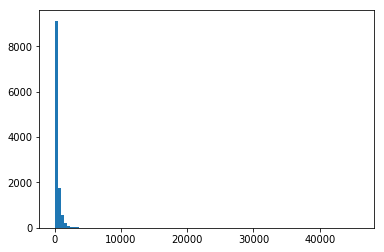

In [12]:
df009 =  df007[df007.tr_mnth.str.slice(0,4)=='2003']
df010 = df009[['customer_id','tr_amt_sale']].groupby('customer_id').sum().reset_index()
df010.columns = ['customer_id', 'tr_amt_sale_nxtyr']
df010['remain'] = 1
plt.hist(df010.tr_amt_sale_nxtyr, bins=100)
df010.head()

(15234, 2)


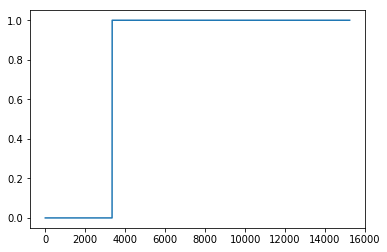

proportion of remaining custs :  0.7805566495995799


,customer_id,remain
0,1114,1.0
1,2900,1.0
2,3224,1.0
3,4860,1.0
4,5313,1.0


In [13]:
df011 = df007[['customer_id']].drop_duplicates().merge(df010[['customer_id','remain']], on='customer_id', how='left' )
df011.remain.fillna(0, inplace=True)
print(df011.shape)
plt.plot(np.sort(df011.remain))
plt.show()
# df011.to_pickle(dataPath + 'df011.pkl')
print('proportion of remaining custs : ', df011.remain.mean())
df011.head()

In [14]:
train_labels = np.array([0])
print(train_labels.shape)

for x in cust_list[:smpl_size]:
    remain_x = df011[df011.customer_id == x]['remain'].values[0]
    train_labels = np.append(train_labels, remain_x)
print(train_labels)
print(train_labels.shape)

test_labels = np.array([0])
print(test_labels.shape)

for x in cust_list[smpl_size:]:
    remain_x = df011[df011.customer_id == x]['remain'].values[0]
    test_labels = np.append(test_labels, remain_x)
print(test_labels)
print(test_labels.shape)

(1,)
[0. 1. 0. ... 0. 1. 0.]
(8001,)
(1,)
[0. 1. 1. ... 1. 0. 1.]
(2777,)


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization
from keras_radam import RAdam
from keras import regularizers
from keras.regularizers import l2

# to adjust learning rate
from keras import optimizers 
optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model = Sequential()
dropout_Rate =0.2 

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(12, 12, 1), activation='relu'))              
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(dropout_Rate))
print(model.output_shape)

model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation='relu', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(dropout_Rate))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation='relu', 
                 strides=(2,2), kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(dropout_Rate))
print(model.output_shape)

model.add(Flatten())

# model.add(Dense(1024, activation='relu'))
model.add(Dense(1024,activation=LeakyReLU(alpha=0.3)))
model.add(BatchNormalization())
model.add(Dropout(dropout_Rate))
print(model.output_shape)

# model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(dropout_Rate))
print(model.output_shape)

# output layer
model.add(Dense(1, activation='sigmoid')) 
# activation = sigmoid for binary numeric target ; softmax for multicategory



model.compile(
  # 'adam',
  RAdam(lr = 0.0005),  
  loss='binary_crossentropy',  # 'categorical_crossentropy' when str type target
  metrics=['MAE'],
)

from keras.utils import to_categorical

history = model.fit(
  train_arr,
  # to_categorical(train_labels), # for multiclass case
  train_labels,  
  epochs=120, # [30, 60, 120]
  batch_size=32,
  shuffle=True,
  verbose=1, validation_split=0.1)

Using TensorFlow backend.


(None, 6, 6, 32)
(None, 1, 1, 128)
(None, 1024)
(None, 256)
Train on 7200 samples, validate on 801 samples
Epoch 1/120
7200/7200 [==============================] - 10s 1ms/step - loss: 0.8391 - mean_absolute_error: 0.4165 - val_loss: 0.6064 - val_mean_absolute_error: 0.3665
Epoch 2/120
7200/7200 [==============================] - 8s 1ms/step - loss: 0.7593 - mean_absolute_error: 0.3837 - val_loss: 0.6268 - val_mean_absolute_error: 0.3618
Epoch 3/120
7200/7200 [==============================] - 7s 1ms/step - loss: 0.7258 - mean_absolute_error: 0.3723 - val_loss: 0.6104 - val_mean_absolute_error: 0.3649
Epoch 4/120
7200/7200 [==============================] - 8s 1ms/step - loss: 0.7113 - mean_absolute_error: 0.3726 - val_loss: 0.6927 - val_mean_absolute_error: 0.3694
Epoch 5/120
7200/7200 [==============================] - 7s 1ms/step - loss: 0.6901 - mean_absolute_error: 0.3688 - val_loss: 0.6006 - val_mean_absolute_error: 0.3593
Epoch 6/120
7200/7200 [==============================] - 

7200/7200 [==============================] - 11s 1ms/step - loss: 0.4971 - mean_absolute_error: 0.3081 - val_loss: 0.6277 - val_mean_absolute_error: 0.3426
Epoch 96/120
7200/7200 [==============================] - 14s 2ms/step - loss: 0.4914 - mean_absolute_error: 0.3033 - val_loss: 0.6426 - val_mean_absolute_error: 0.3404
Epoch 97/120
7200/7200 [==============================] - 15s 2ms/step - loss: 0.4872 - mean_absolute_error: 0.3005 - val_loss: 0.6224 - val_mean_absolute_error: 0.3564
Epoch 98/120
7200/7200 [==============================] - 8s 1ms/step - loss: 0.4927 - mean_absolute_error: 0.3022 - val_loss: 0.6613 - val_mean_absolute_error: 0.3371
Epoch 99/120
7200/7200 [==============================] - 7s 975us/step - loss: 0.4973 - mean_absolute_error: 0.3069 - val_loss: 0.6256 - val_mean_absolute_error: 0.3545
Epoch 100/120
7200/7200 [==============================] - 7s 998us/step - loss: 0.4903 - mean_absolute_error: 0.3015 - val_loss: 0.6853 - val_mean_absolute_error: 0.33

In [177]:
## Keras Conv2D and Convolutional Layers :: 
## 128X128 미만에서는 (3,3) 이 기본
## 보통은 strides = (1,1) default 사용
## pooling 대신 strides를 키우는 것이 유용한 경우도 존재

## https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/ 

dict_keys(['val_loss', 'mean_absolute_error', 'loss', 'val_mean_absolute_error'])
min 1% validation loss :  0.5692567559879519


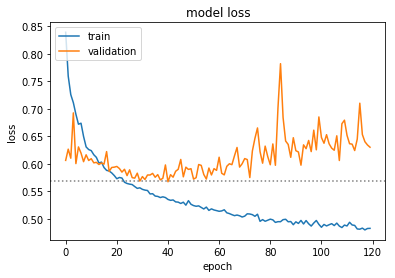

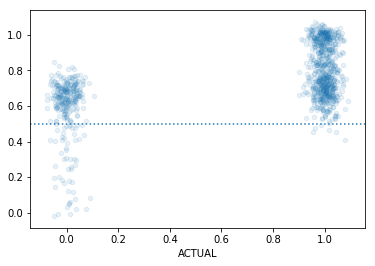

accuracy%  74.8
corr =  0.531905419843845

----------
[ USING TEST SET ]

(2777, 12, 12, 1) 3000
[0.6685614  0.72369444 0.57842004 0.98248726 0.66328    0.65030986
 0.65138614 0.63433516 0.64594066 0.68747    0.5868791  0.8862823
 0.9849753  0.637517   0.7273479  0.9909456  0.92324054 0.9816985
 0.9997663  0.9996208  0.6562954  0.8225274  0.7034719  0.56924593
 0.65111846 0.9876537  0.6941902  0.6430474  0.9300275  0.9986817 ] 0.016417209 ~ 0.9999993


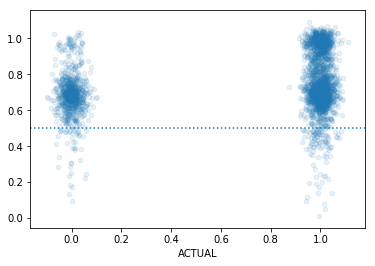

accuracy%  68.23910694994598


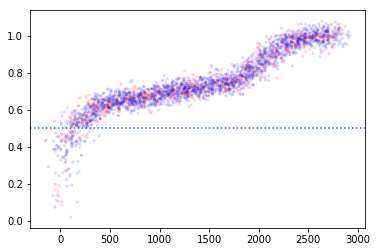

corr =  0.2442624162526208
[[  40  783]
 [  99 1855]]


In [16]:
print(history.history.keys())
print('min 1% validation loss : ', np.percentile(history.history['val_loss'],1))

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.axhline(np.percentile(history.history['val_loss'],1), color='grey', linestyle=':')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

n_predict = 1000

predictions = model.predict(train_arr[:n_predict])
# predicted = np.argmax(predictions, axis=1)
actual = train_labels[:n_predict].astype(int)
# print(predicted, actual)

# plt.scatter(rjitt2(actual ), rjitt2(predicted ), s=20, alpha=0.1)
# plt.xlabel('ACTUAL')
# plt.show()

plt.scatter(rjitt2(actual), rjitt2(predictions[:,0] ), s=20, alpha=0.1)
plt.xlabel('ACTUAL')
plt.axhline(0.5, linestyle=':')
plt.show()


df_predeval = pd.DataFrame({'actl': actual,
              'pred':predictions[:,0]})
df_predeval['predc'] = np.where(df_predeval.pred>0.5, 1, 0)
print('accuracy% ', df_predeval[df_predeval.predc==df_predeval.actl].shape[0] / df_predeval.shape[0] *100)

# getting correlation coefficient
print('corr = ', df_predeval.pred.corr(df_predeval.actl))


#--- using test set --------
# 
#
print('\n----------\n[ USING TEST SET ]\n')

n_predict1 = n_predict *3

print(test_arr.shape, n_predict1)


predictions = model.predict(test_arr[:n_predict1])[:,0]
print(predictions[:30], predictions.min(), '~', predictions.max())
# predictions = (model.predict(test_arr[:n_predict1]) -0.5) *2
# predicted = np.argmax(predictions, axis=1)
actual = test_labels[:n_predict1].astype(int)

# plt.scatter(rjitt2(actual ), rjitt2(predicted ), s=20, alpha=0.1)
# plt.xlabel('ACTUAL')
# plt.show()

plt.scatter(rjitt2(actual), rjitt2(predictions), s=20, alpha=0.1)
plt.xlabel('ACTUAL')
plt.axhline(0.5, linestyle=':')
plt.show()

df_predeval = pd.DataFrame({'actl': actual,
              'pred':predictions})
df_predeval['predc'] = np.where(df_predeval.pred>0.5, 1, 0)
print('accuracy% ', df_predeval[df_predeval.predc==df_predeval.actl].shape[0] / df_predeval.shape[0] *100)

df_predevals = df_predeval.sort_values('pred')

xindx = range(1,len(df_predevals.pred)+1)
tmpindc = abs(df_predeval.pred - df_predeval.actl)
colors1 = ['red' if x >0.5 else 'blue' for x in tmpindc]
plt.scatter(rjitt2(xindx), rjitt2(df_predevals.pred),
            s=5, alpha=0.1,
           color = colors1)
plt.axhline(0.5, linestyle=':')
plt.show()

# getting correlation coefficient
print('corr = ', df_predeval.pred.corr(df_predeval.actl))


from sklearn.metrics import confusion_matrix

# confusion matrix
cm = confusion_matrix(df_predeval.actl, df_predeval.predc)
print(cm)